In [2]:
from modeling import *
from peristimulus import *
import seaborn as sns
from scipy.stats import spearmanr, shapiro
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.tsatools import lagmat
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import matplotlib as mpl

plt.subplots_adjust(wspace=0.2, hspace=0.3)
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams["legend.fontsize"] = "x-large"
mpl.rcParams['figure.titlesize'] = 22

<Figure size 432x288 with 0 Axes>

In [8]:
folder = "/home/wholebrain/Documents/U19/ProbSwitch_FP_data"
get_probswitch_session_by_condition(folder, group='all', region='NAc', signal='all')

{'D1': {'D1-27H_LT': ['p103_FP_RH', 'p189_FP_RH'],
  'D1-28B_LT': ['p135_session2_FP_LH']},
 'A2A': {'A2A-15B-B_RT': ['p153_FP_LH', 'p238_FP_LH'],
  'A2A-19B_RT': ['p139_FP_LH', 'p148_FP_LH'],
  'A2A-19B_RV': ['p142_FP_RH']}}

In [4]:
#folder = "/Volumes/ALBERTSHD/WilbrechtLab/CADA_data/ProbSwitch_FP_data"
folder = "/Users/albertqu/Documents/7.Research/Wilbrecht_Lab/CADA_data/ProbSwitch_FP_data"
#plot_out = "/Users/albertqu/Documents/7.Research/Wilbrecht_Lab/CADA_plots/FP_NAc_D1D2_CADA/mvmt_times"
plot_out = "/Users/albertqu/Documents/7.Research/Wilbrecht_Lab/CADA_plots/FP_NAc_D1D2_CADA/belief_state"
animal, session = "A2A-15B-B_RT", "p153_FP_LH"
region = 'NAc'
time_window_dict = {'center_in': np.arange(-500, 501, 50),
                    'center_out': np.arange(-500, 501, 50),
                    'outcome': np.arange(-500, 2001, 50),
                    'side_out': np.arange(-500, 1001, 50)}
#animal, session = "D1-27H_LT", "p103_FP_RH"
#animal, session = "A2A-15B-B_RT", "p151_session2_FP_RH" # DMS


In [11]:
folder = "/home/wholebrain/Documents/U19/ProbSwitch_FP_data"
#folder = "/Users/albertqu/Documents/7.Research/Wilbrecht_Lab/CADA_data/ProbSwitch_FP_data"
plot_out = "/home/wholebrain/Documents/U19/CADA_plots/FP_NAc_D1D2_CADA/belief_state"
time_window_dict = {'center_in': np.arange(-500, 501, 50),
                    'center_out': np.arange(-500, 501, 50),
                    'outcome': np.arange(-500, 2001, 50),
                    'side_out': np.arange(-500, 1001, 50)}
# for region in ['NAc', 'DMS']:
#     session_conds = get_probswitch_session_by_condition(folder, group='all', region=region, signal='all')
#     for group in session_conds:
#         group_dict = session_conds[group]
#         for animal in group_dict:
#             for session in group_dict[animal]:
#                 print(animal, session, region)
#                 decoder_model_pipeline(folder, animal, session, os.path.join(plot_out, region))

In [12]:
def df_col_is_str(df, c):
    return df[c].dtype == object and isinstance(df.iloc[0][c], str)

def map_feature_to_alias(features, maps, old_header):
    features[old_header+'_old'] = features[old_header]
    new_header = old_header
    old_header = old_header+'_old'
    #print(new_header, old_header)
    for mm in maps:
        features[new_header][features[old_header] == mm] = maps[mm]
    return features

def merge_features(feature_mat, features):
    assert len(features) > 0, 'Why are you messing around with empty features bro?'
    # convert merge features into str"
    for ff in features:
        if not df_col_is_str(feature_mat, ff):
            feature_mat[ff] = feature_mat.astype(str)
    new_header = "_".join(features)
    feature_mat[new_header] = feature_mat[features[0]]
    temp = feature_mat[new_header]
    for ii in range(1, len(features)):
        temp = temp + '_' + feature_mat[features[ii]]
    invalids = np.logical_or.reduce([feature_mat[ff] == '' for ff in features])
    temp[invalids] = ''
    feature_mat[new_header] = temp
    return feature_mat

def ITI_bin_sort(bin_tags):
    if isinstance(bin_tags, list):
        bin_tags = np.array(bin_tags)
    if '' in bin_tags:
        bin_tags = bin_tags[bin_tags != '']
    return sorted(bin_tags, key=lambda bt: int(bt[1:].split(',')[0]))

def drop_empty_nan(df):
    return df[np.logical_and.reduce([df[c] != '' for c in df.columns if df_col_is_str(df, c)])].dropna()

def feature_sels_to_array(tags, sels):
    efeatures = np.full(len(sels[0]), "", dtype=f'<U{len(max(tags, key=len))}')
    for i in range(len(sels)):
        efeatures[sels[i]] = tags[i]
    return efeatures

def array_to_feature_sels(feature_array, drop_empty=True):
    removal = [""] if drop_empty else []
    return {ff: feature_array == ff for ff in np.unique(feature_array) if ff not in removal}

def aligned_FP_to_df(mat, fp_sigs, fp_times, behavior_args, time_window_dict):
    behavior_times = np.vstack([get_behavior_times_old(mat, beh) for beh in behavior_args])
    dfs = []
    for i, sig in enumerate(['DA', 'Ca']):
        raw_features = np.concatenate([[f'{sig}_{beh}({ts:.0f})' for ts in time_window_dict[beh.split('{')[0]]] for beh in behavior_args])
        dfmat = pd.DataFrame(np.full((behavior_times.shape[1], len(raw_features)), np.nan), columns=raw_features)
        for j in range(behavior_times.shape[0]):
            behavior_arg = behavior_args[j]
            df_arg = f'{sig}_{behavior_arg}'
            col_selected = [c for c in raw_features if df_arg in c]
            nonan_sel = ~np.isnan(behavior_times[j])
            aligned_nonan = align_activities_with_event(fp_sigs[i], fp_times[i], behavior_times[j][nonan_sel],
                                                          time_window_dict[behavior_arg.split('{')[0]], False)
            dfmat.loc[nonan_sel, col_selected] = aligned_nonan
        dfs.append(dfmat)
    return pd.concat(dfs, axis=1)

def get_columns_FP_df(dfmat, arg):
    return [c for c in dfmat.columns if arg in c]

def behavior_col2times(col_names):
    if isinstance(col_names, str):
        return int(col_names.split('}')[1:-1])
    else:
        return np.array([behavior_col2times(cn) for cn in col_names])
    
def get_default_feature_df(mat, animal, session, prepost=(-2, 0)):
#     all_features = ['R{t-2}', 'R{t-1}', 'A{t-2}', 'A{t-1}']
    pre, post = prepost
    preR, postR = range(pre, 0), range(1, post+1)
    Rseq = ['R{t%d}' % (n) for n in preR] + ['R{t+%d}' % (n) for n in postR]
    Aseq = ['A{t%d}' % (n) for n in preR] + ['A{t+%d}' % (n) for n in postR]
    all_features = Rseq + Aseq 
    fmaps = {'R': {'Rewarded': 'R', 'Unrewarded': 'U', '': ''}}
    rew_feature = get_trial_features_old(mat, 'R', as_array=True)
    side_feature = get_trial_features_old(mat, 'A', as_array=True)
#     data = np.vstack([trial_vector_time_lag(rew_feature, -2), trial_vector_time_lag(rew_feature, -1),
#                       trial_vector_time_lag(side_feature, -2), trial_vector_time_lag(side_feature, -1)]).T
    data = np.vstack([trial_vector_time_lag(rew_feature, n) for n in preR] +
                     [trial_vector_time_lag(rew_feature, n) for n in postR] +
                     [trial_vector_time_lag(side_feature, n) for n in preR] +
                     [trial_vector_time_lag(side_feature, n) for n in postR]).T
    feature_mat = pd.DataFrame(data, columns=all_features)
    feature_mat['R'] = rew_feature
    feature_mat['A'] = side_feature
    for ff in ['R']+Rseq:
        feature_mat = map_feature_to_alias(feature_mat, fmaps[ff.split('{')[0]], ff)
    feature_mat = merge_features(feature_mat, all_features)
    center_in_times = get_behavior_times_old(mat, 'center_in').ravel()
    side_out_times = get_behavior_times_old(mat, 'side_out{t-1}').ravel()
    mvmt_times = center_in_times - side_out_times
    #print(mvmt_times.shape, feature_mat.shape)
    feature_mat['MVT'] = mvmt_times
    feature_mat['MVT_bin'] = ''
    feature_mat['MVT_binN'] = ''
    return feature_mat


def complete_df_MVT_bin(eventFP_mat):
    assert ('MVT_bin' in eventFP_mat.columns) and ('MVT_binN' in eventFP_mat.columns)
    # calculate ITI:
    rf1back = eventFP_mat['R{t-1}']
    mvmt_times = eventFP_mat['MVT']
    mvmt_nonan = ~np.isnan(mvmt_times)
    rew_1shift, unrew_1shift = (rf1back == 'R'), (rf1back == 'U')
    rew_mvmts = mvmt_times[mvmt_nonan & rew_1shift]
    unrew_mvmts = mvmt_times[mvmt_nonan & unrew_1shift]
    rew_bins = list(np.percentile(rew_mvmts, [25, 50, 75])) + [4000]
    unrew_bins = list(np.percentile(unrew_mvmts, [25, 50, 75])) + [4000]
    print('Reward Bin:', rew_bins)
    print('Unrew bin:', unrew_bins)

    # rew_mvmts_nonan = mvmt_times[nonan_sel & rew_outcome['Rewarded']]
    # unrew_mvmts_nonan = mvmt_times[nonan_sel & rew_outcome['Unrewarded']]
    
    round_int = lambda x: int(np.around(x))
    full_rew_bins = [0] + rew_bins
    rew_intervals = [(round_int(full_rew_bins[i]), round_int(full_rew_bins[i + 1])) for i in
                     range(len(full_rew_bins) - 1)]
    rew_intervals_tags = [str(itvl) for itvl in rew_intervals]

    rew_iti_bins = [(mvmt_times > itvl[0]) & (mvmt_times <= itvl[1]) & rew_1shift for itvl in
                    rew_intervals]
    full_unrew_bins = [0] + unrew_bins
    unrew_intervals = [(round_int(full_unrew_bins[i]), round_int(full_unrew_bins[i + 1])) for i in
                       range(len(full_unrew_bins) - 1)]
    unrew_intervals_tags = [str(itvl) for itvl in unrew_intervals]
    unrew_iti_bins = [(mvmt_times > itvl[0]) & (mvmt_times <= itvl[1]) & unrew_1shift for itvl in
                      unrew_intervals]
    ITI_bin_array = feature_sels_to_array(rew_intervals_tags + unrew_intervals_tags,
                                          np.vstack([rew_iti_bins, unrew_iti_bins]))
    binnums = [f'bin{ib}' for ib in range(1, len(rew_intervals) + 1)]
    ITI_bin_num_array = feature_sels_to_array(binnums + binnums,
                                              np.vstack([rew_iti_bins, unrew_iti_bins]))
    eventFP_mat['MVT_bin'] = ITI_bin_array
    eventFP_mat['MVT_binN'] = ITI_bin_num_array
    return eventFP_mat


def animal_session_to_event_mat(folder, animal, session, region, prepost=(-4, 0), event='outcome'):
    # TODO: relax event to take list instead, also the prepost might incur issues for the decoding model!
    zscore = True
    base_method = 'robust_fast'
    denoise = True

    time_window_dict = {'center_in': np.arange(-500, 501, 50),
                        'center_out': np.arange(-500, 501, 50),
                        'outcome': np.arange(-500, 2001, 50),
                        'side_out': np.arange(-500, 1001, 50)}
    tags = ['DA', 'Ca']
    fit_models = ['RandomForests']

    files = encode_to_filename(folder, animal, session, ['green', 'red', 'FP', 'behavior_old', 'processed'])
    matfile, green, red, fp = files['behavior_old'], files['green'], files['red'], files['FP']
    # Load FP
    if fp is not None:
        with h5py.File(fp, 'r') as fp_hdf5:
            fp_sigs = [access_mat_with_path(fp_hdf5, f'{tags[i]}/dff/{base_method}')
                       for i in range(len(tags))]
            if zscore:
                fp_sigs = [(fp_sigs[i] - np.mean(fp_sigs[i])) / np.std(fp_sigs[i], ddof=1)
                           for i in range(len(fp_sigs))]
            fp_times = [access_mat_with_path(fp_hdf5, f'{tags[i]}/time') for i in
                        range(len(tags))]
    else:
        print(f"Warning {animal} {session} does not have photometry processed!")
        fp_times, fp_sigs, iso_times, iso_sigs = get_sources_from_csvs([green, red],
                                                                       tags=('DA', 'Ca'), show=False)

        fp_sigs = [raw_fluor_to_dff(fp_times[i], fp_sigs[i], iso_times[i], iso_sigs[i], base_method,
                                    zscore=zscore) for i in range(len(fp_sigs))]
    if denoise:
        L = len(fp_times)
        new_times, new_sigs = [None] * L, [None] * L
        for i in range(L):
            new_sigs[i], new_times[i] = denoise_quasi_uniform(fp_sigs[i], fp_times[i])
        fp_sigs, fp_times = new_sigs, new_times
        # TODO: for now just do plots for one session

    mat = h5py.File(matfile, 'r')
    # Find a more intelligent solution with time lagging
    pre, post = prepost
    preR, postR = range(pre, 0), range(1, post+1)
    behavior_args = [event+'{t%d}' % n for n in preR] + [event+'{t}'] + [event+'{t+%d}' % n for n in postR]
    dfmat = aligned_FP_to_df(mat, fp_sigs, fp_times,
                             behavior_args, time_window_dict)
    feature_mat = get_default_feature_df(mat, animal, session, prepost)
    header_mat = pd.DataFrame({'trial': np.arange(get_trial_num(mat))})
    header_mat['animal'], header_mat['session'] = animal, session
    header_mat['region'] = region
    eventFP_mat = pd.concat([header_mat, feature_mat, dfmat], axis=1)
    return eventFP_mat

def eventFP_mat_dimred(eFPmat_clean, event_sig, window_sel, ncomp='mean', returnPCA=False):
    # Assumes the mean is taken with a continuous chunk!
    # Better method for AUC
    assert isinstance(eFPmat_clean, pd.DataFrame) & (np.sum(eFPmat_clean.values == '') == 0), 'Has to be clean'
    animals = np.unique(eFPmat_clean['animal'])
    all_sessions = np.unique(eFPmat_clean['session'])
    if (len(animals) > 1) or (len(all_sessions) > 1):
        red_mats = []
        for anim in sorted(animals):
            anim_mat = eFPmat_clean[eFPmat_clean['animal'] == anim]
            sessions = sorted(np.unique(anim_mat['session']))
            for ses in sessions:
                red_mats.append(eventFP_mat_dimred(anim_mat[anim_mat['session'] == ses], 
                                                   event_sig, window_sel, ncomp))
        return pd.concat(red_mats, axis=0, ignore_index=True)
    
    cnames = np.array(get_columns_FP_df(eFPmat_clean, event_sig))[window_sel]
    fp_select = eFPmat_clean[cnames].values
    start=int(cnames[0].split('}')[1][1:-1])
    end=int(cnames[-1].split('}')[1][1:-1])
    if ncomp == 'mean':
        Xred = pd.DataFrame({f'{event_sig}_mean({start},{end})': np.mean(fp_select, axis=1)})
    elif ncomp == 'peakridge':
        data = fp_select
        mm = np.mean(data, axis=1)
        pr = np.empty(len(data))
        pr[mm >=0] = np.max(data[mm >=0], axis=1)
        pr[mm < 0] = np.min(data[mm < 0], axis=1)  
        Xred = pd.DataFrame({f'{event_sig}_peakridge': pr})
    elif ncomp == 'conv_vtx':
        data = fp_select
        ab = np.abs(data)
        Xred = pd.DataFrame({f'{event_sig}_conv_vtx': 
                             data[np.arange(len(data)), np.argmax(ab, axis=1)]})
    elif ncomp == 0:
        Xred = pd.DataFrame(fp_select, columns=cnames)
    else:
        pca = PCA(n_components=ncomp, whiten=True, random_state=0)
        Xred = pd.DataFrame(pca.fit_transform(fp_select), 
                            columns=[f'{event_sig}_PC{j+1}' for j in range(ncomp)])
        if returnPCA:
            print('DOS')
            return Xred, pca
    return Xred

def sklearn_logregcv_best_score(model, whole_dist=False):
    bac_scores = np.mean([model.scores_[b] for b in model.scores_], axis=0)
    if whole_dist:
        arg = np.argmax(np.mean(bac_scores, axis=0))
        return bac_scores[:, arg]
    return np.max(np.mean(bac_scores, axis=0), axis=0)

def decode_neural_to_behavior(eventFP_mat, FP_sample_arg, dep_arg):
    # FP_sample_arg: behavior_arg, window_sel_arg, lag_arg, ncomp_args
    # TODO: only supports negative
    # Start with logistic regression (Test set also)
    # Compare D1, D2 animals (add {t-3, t-4} does not change much); can the bias predict animal bias?
    # TODO: add bootstrapping CI
    behavior_arg, window_sel_arg, lag_arg, ncomp_args = FP_sample_arg
    dep_feat, dep_bin = dep_arg
    fmat0 = drop_empty_nan(eventFP_mat)

    tw_sels = {behavior_arg[i]: window_sel_arg[i] for i in range(len(behavior_arg))}
    ncomp_sels = {behavior_arg[i]: ncomp_args[i] for i in range(len(behavior_arg))}

    lag_arg_to_str = lambda lag: ('{t' + str(int(lag)) + '}') if lag else '{t}'
    FP_samples = np.concatenate([[f'{behavior_arg[i]}{lag_arg_to_str(l)}'
                                  for l in lag_arg[i]] for i in range(len(behavior_arg))])

    Xlog = []
    for ifsp, fsp in enumerate(FP_samples):
        #ncomp = ncomp_sels[fsp.split('{')[0]]
        # Xlog.append(eventFP_mat_dimred(fmat0[logsel], fsp, twindow_sels[fsp], ncomp))
        barg = fsp.split('{')[0]
        Xlog.append(eventFP_mat_dimred(fmat0, fsp, tw_sels[barg], ncomp_sels[barg]))
    Xlogs = Xlog
    # Xlog, ylog = pd.concat(Xlog, axis=1), (fmat0[logsel]['A'] == 'contra').astype(np.int)

    designmat = pd.concat(Xlog, axis=1)
    if dep_bin is not None:
        y = (fmat0[dep_feat] == dep_bin).astype(np.int)
    else:
        y = fmat0[dep_feat]

    # Xlog = pd.DataFrame(StandardScaler().fit_transform(Xlog), columns=Xlog.columns)
    # multi_class{‘auto, ‘ovr’, ‘multinomial’}
    cvm = sklearn.model_selection.StratifiedShuffleSplit(100, random_state=0)
    # cvm = 5
    if len(np.unique(y)) > 2:
        model_choice = LogisticRegressionCV(cv=cvm, solver='saga', penalty='l1', multi_class='multinomial',
                                               random_state=0, max_iter=1000).fit(designmat, y)
    else:
        model_choice = LogisticRegressionCV(cv=cvm, solver='saga',
                                                penalty='l1', random_state=0, max_iter=1000).fit(designmat, y)
    

    best_score_dist = sklearn_logregcv_best_score(model_choice, whole_dist=True)
    return model_choice, designmat, y, fmat0, best_score_dist

def visualize_model_accuracy(eventFP_mat, window_sel_arg, lag_arg, ncomp_args, dep_arg, plot_out=None):
    behCa = ['Ca_outcome']
    behboth = ['DA_outcome', 'Ca_outcome']
    fast_map = {'A2A': 'iSPN', 'D1': 'dSPN'}
    indiv_scores = [None] * 3
    for i, beh in enumerate(behboth):
        ibehavior_arg = [beh]
        iwindow_sel_arg = [window_sel_arg[i]]
        ilag_arg = [lag_arg[i]]
        incomp_args = [ncomp_args[i]]
        log_model_choice, Xlog, ylog, fmat0, best_score = decode_neural_to_behavior(eventFP_mat,
                                                                                    (ibehavior_arg,
                                                                                     iwindow_sel_arg,
                                                                                     ilag_arg,
                                                                                     incomp_args), dep_arg)
        indiv_scores[i] = best_score
    log_model_choice, Xlog, ylog, fmat0, best_score = decode_neural_to_behavior(eventFP_mat,
                                                                                (behboth, window_sel_arg,
                                                                                lag_arg, ncomp_args),dep_arg)
    indiv_scores[2] = best_score
    CaType = fast_map[eventFP_mat['animal'].values[0].split('-')[0]]
    animals = np.unique(eventFP_mat['animal'])
    all_sessions = np.unique(eventFP_mat['session'])
    region = eventFP_mat['region'].values[0]
    print(animals, all_sessions, eventFP_mat['animal'].values[0].split('-')[0] + f'_{region}')
    if (len(animals) > 1) or (len(all_sessions) > 1):
        animal = eventFP_mat['animal'].values[0].split('-')[0] + f'_{region}'
        session = 'multisession'
    else:
        animal, session = eventFP_mat['animal'].values[0], eventFP_mat['session'].values[0]
    
    xlabels = ['dLight', f'jRGECO {CaType}', 'both']

    dep = {'A': 'Choice', 'MVT_bin': 'Movement Times Bins', 'MVT_binN': 'Movement Time Quartiles'}[dep_arg[0]]

    ntrial = -np.min(lag_arg[0])
    mean_scores = np.mean(indiv_scores, axis=0)
    all_normal = True
    for im in range(3):
        stat, pv = shapiro(indiv_scores[im])
        if pv > 0.05:
            all_normal=False
    Kmeas = len(indiv_scores[0])

    std_scores = np.std(indiv_scores, ddof=1, axis=0) / np.sqrt(Kmeas)
    plt.figure(figsize=(10, 8))
    wholeDF = pd.DataFrame({'type': np.repeat(xlabels, Kmeas), 
                            'Decoder Accuracy': np.ravel(indiv_scores, order='C')})
    sns.barplot(x='type', y='Decoder Accuracy', data=wholeDF, ci=95)
    plt.ylim((0, 0.9))
    # plt.bar(np.arange(3), mean_scores, yerr=std_scores)
    # plt.xticks(np.arange(3), xlabels)
    # plt.xlabel('type')
    # plt.ylabel('Decoder Accuracy')
    # TODO: Generalize
    plt.title(f'Comparison of {dep} Predictions with \n different {region} signal type \n'
              f'Outcome Phase {ntrial} back')
    if plot_out is not None:
        plt.savefig(os.path.join(plot_out, f'decoder_comp_{ntrial}_{dep.lower()}_{animal}_{session}'))
    return wholeDF


def visualize_weights(ws, names, ignore_thres=0.001):
    # TODO: include bootstrapping after
    colors = sns.diverging_palette(240, 10, n=1)
    plt.figure(figsize=(15, 10))
    betas = ws
    betas_nonzero = np.abs(betas) >= ignore_thres
    betas_trimmed = betas[betas_nonzero]
    beta_sorts = np.argsort(betas_trimmed)
    xs = np.arange(len(betas_trimmed))
    plt.barh(xs, betas_trimmed[beta_sorts], color=colors[0])
    tk=plt.yticks(xs, names[betas_nonzero][beta_sorts])

def visualize_feature_weights_decoder(eventFP_mat, plot_out=None):
    DAosel0 = (time_window_dict['outcome'] <= 1500)
    Caosel0 = time_window_dict['outcome'] <= 1500

    behavior_arg = ['Ca_outcome']
    window_sel_arg = [Caosel0]
    lag_arg = [[-1, -2, -3, -4]]
    ncomp_args = [7]
    dep_arg = ['A', 'contra']
    ntrial = -np.min(lag_arg[0])
    dep = {'A': 'Choice', 'MVT': 'Movement Times', 'MVT_binN': 'Movement Time Quartiles'}[dep_arg[0][0]]
    # Xlog, ylog = pd.concat(Xlog, axis=1), (fmat0['A{t-1}'] == 'contra').astype(np.int)
    # Xlog, ylog = pd.concat(Xlog, axis=1), fmat0['MVT_bin']

    log_model_choice, Xlog, ylog, fmat0, best_score= decode_neural_to_behavior(eventFP_mat, (behavior_arg, 
                                                               window_sel_arg, lag_arg, ncomp_args), dep_arg)
    betas = log_model_choice.coef_[0, :]
    visualize_weights(betas, Xlog.columns)
    animals = np.unique(eventFP_mat['animal'])
    all_sessions = np.unique(eventFP_mat['session'])
    region = eventFP_mat['region'].values[0]
    if (len(animals) > 1) or (len(all_sessions) > 1):
        animal = eventFP_mat['animal'].values[0].split('-')[0] + f'_{region}'
        session = 'multisession'
    else:
        animal, session = eventFP_mat['animal'].values[0], eventFP_mat['session'].values[0]
    plt.title(f'decoding_{ylog.name}') 
    if plot_out is not None:
        plt.savefig(os.path.join(plot_out, f'log_reg_beta_weights_{ntrial}back_{dep.lower()}_{animal}_{session}.png'))

In [13]:
def decoder_model_pipeline(folder, animal, session, plot_out):
    if not os.path.exists(plot_out):
        os.makedirs(plot_out)
    zscore = True
    base_method = 'robust_fast'
    denoise = True

    time_window_dict = {'center_in': np.arange(-500, 501, 50),
                        'center_out': np.arange(-500, 501, 50),
                        'outcome': np.arange(-500, 2001, 50),
                        'side_out': np.arange(-500, 1001, 50)}
    tags = ['DA', 'Ca']
    fit_models = ['RandomForests']

    files = encode_to_filename(folder, animal, session, ['green', 'red', 'FP', 'behavior_old', 'processed'])
    matfile, green, red, fp = files['behavior_old'], files['green'], files['red'], files['FP']
    # Load FP
    if fp is not None:
        with h5py.File(fp, 'r') as fp_hdf5:
            fp_sigs = [access_mat_with_path(fp_hdf5, f'{tags[i]}/dff/{base_method}')
                       for i in range(len(tags))]
            if zscore:
                fp_sigs = [(fp_sigs[i] - np.mean(fp_sigs[i])) / np.std(fp_sigs[i], ddof=1)
                           for i in range(len(fp_sigs))]
            fp_times = [access_mat_with_path(fp_hdf5, f'{tags[i]}/time') for i in
                        range(len(tags))]
    else:
        print(f"Warning {animal} {session} does not have photometry processed!")
        fp_times, fp_sigs, iso_times, iso_sigs = get_sources_from_csvs([green, red],
                                                                       tags=('DA', 'Ca'), show=False)

        fp_sigs = [raw_fluor_to_dff(fp_times[i], fp_sigs[i], iso_times[i], iso_sigs[i], base_method,
                                    zscore=zscore) for i in range(len(fp_sigs))]
    if denoise:
        L = len(fp_times)
        new_times, new_sigs = [None] * L, [None] * L
        for i in range(L):
            new_sigs[i], new_times[i] = denoise_quasi_uniform(fp_sigs[i], fp_times[i])
        fp_sigs, fp_times = new_sigs, new_times
        # TODO: for now just do plots for one session

    mat = h5py.File(matfile, 'r')
    region = 'NAc' if np.array(mat['glml/notes/region']).item() else 'DMS'
    event_types = ['center_in{t-1}', 'center_in', 'center_out{t-1}', 'center_out', 'outcome{t-2}',
                   'outcome{t-1}', 'outcome', 'side_out{t-1}']
    trial_feature = "A"
    # Get aligned signals to behaviors
    aligned = [[] for _ in range(len(fp_sigs))]
    behavior_times = np.vstack([get_behavior_times_old(mat, beh) for beh in event_types])
    nonan_sel = ~np.any(np.isnan(behavior_times), axis=0)
    behavior_times_nonan = behavior_times[:, nonan_sel]
    behavior_time_map = {event_types[i]: i for i in range(len(behavior_times))}
    for ib, beh in enumerate(event_types):
        # TODO: ADD caps for multiple behavior time latencies
        for i in range(len(fp_sigs)):
            aligned[i].append(align_activities_with_event(fp_sigs[i], fp_times[i], behavior_times_nonan[ib],
                                                          time_window_dict[beh.split('{')[0]], False))
    # calculate ITI:
    rf = get_trial_features_old(mat, 'R', as_array=True)
    rew_outcome = array_to_feature_sels(trial_vector_time_lag(rf, -1))
    # rew_outcome = get_trial_features_old(mat, 'R', False)
    mvmt_times = behavior_times[behavior_time_map['center_in']] - behavior_times[
        behavior_time_map['side_out{t-1}']]
    mvmt_nonan = ~np.isnan(mvmt_times)
    rew_mvmts = mvmt_times[mvmt_nonan & rew_outcome['Rewarded']]
    unrew_mvmts = mvmt_times[mvmt_nonan & rew_outcome['Unrewarded']]
    rew_bins = list(np.percentile(rew_mvmts, [25, 50, 75])) + [4000]
    unrew_bins = list(np.percentile(unrew_mvmts, [25, 50, 75])) + [4000]
    rew_mvmts_nonan = mvmt_times[nonan_sel & rew_outcome['Rewarded']]
    unrew_mvmts_nonan = mvmt_times[nonan_sel & rew_outcome['Unrewarded']]
    unrew_bin1 = unrew_mvmts_nonan <= unrew_bins[0]
    unrew_bin2 = (unrew_bins[0] < unrew_mvmts_nonan) & (unrew_mvmts_nonan <= unrew_bins[1])
    unrew_bin3 = (unrew_bins[1] < unrew_mvmts_nonan) & (unrew_mvmts_nonan <= unrew_bins[2])
    unrew_bin4 = (unrew_bins[2] < unrew_mvmts_nonan) & (unrew_mvmts_nonan <= unrew_bins[3])
    # plt.figure(figsize=(20, 15))
    # plt.subplot(211)
    # plt.hist(mvmt_times[mvmt_nonan & rew_outcome['Rewarded']], density=True, range=(0, 4000))
    # plt.title('rewarded')
    # plt.subplot(212)
    # plt.hist(mvmt_times[mvmt_nonan & rew_outcome['Unrewarded']], density=True, range=(0, 4000))
    # plt.title('unrewarded')


    eventFP_mat = animal_session_to_event_mat(folder, animal, session, region)
    eventFP_matcomplete_df_MVT_bin(eventFP_mat)
    DAosel0 = (time_window_dict['outcome'] <= 1500)
    Caosel0 = time_window_dict['outcome'] <= 1500

    behavior_arg = ['Ca_outcome']
    window_sel_arg = [Caosel0]
    lag_arg = [[-1, -2, -3, -4]]
    ncomp_args = [7]
    dep_arg = ['A', 'contra']

    window_sel_arg_cp = [DAosel0, Caosel0]
    lag_arg_cp = [[-1, -2, -3, -4], [-1, -2, -3, -4]]
    ncomp_args_cp = [7, 7]
    dep_arg_cp = ['A', 'contra']
    visualize_model_accuracy(eventFP_mat, window_sel_arg_cp, lag_arg_cp, ncomp_args_cp, dep_arg_cp, plot_out)

    visualize_feature_weights_decoder(eventFP_mat, plot_out)

### Choice Prediction: Ca Dominates!

In [6]:
# # Start with logistic regression (Test set also)
# # Compare D1, D2 animals (add {t-3, t-4} does not change much); can the bias predict animal bias?
# # TODO: add bootstrapping CI 
# fmat0 = drop_empty_nan(eventFP_mat)
# logsel = (fmat0['R{t-1}'] == 'U') & (fmat0['R{t-2}'] == 'U') & (fmat0['A{t-1}'] == fmat0['A{t-2}'])
# #DAosel0 = (time_window_dict['outcome']>=500) & (time_window_dict['outcome']<=1500)
# DAosel0 = (time_window_dict['outcome']<=1500)
# Caosel0 = time_window_dict['outcome']<= 1500
# # twindow_sels = {'DA_outcome{t-1}': DAosel0,
# #                'DA_outcome{t-2}': DAosel0,
# #                'DA_outcome{t-3}': DAosel0,
# #                'DA_outcome{t-4}': DAosel0,
# #                'Ca_outcome{t-1}': Caosel0,
# #                'Ca_outcome{t-2}': Caosel0,
# #                'Ca_outcome{t-3}': Caosel0,
# #                'Ca_outcome{t-4}': Caosel0}
# # dim_red_grid = {'Ca_outcome': 7, 'DA_outcome': 7} # Ca=0
# # #FP_samples = ['Ca_outcome{t-2}', 'Ca_outcome{t-1}', 'DA_outcome{t-2}', 'DA_outcome{t-1}']
# # #FP_samples = ['DA_outcome{t-2}', 'DA_outcome{t-1}']
# # # FP_samples = ['Ca_outcome{t-2}', 'Ca_outcome{t-1}',
# # #               'DA_outcome{t-2}', 'DA_outcome{t-1}']
# # FP_samples = ['Ca_outcome{t-1}', 'Ca_outcome{t-2}']
# # #FP_samples = ['Ca_outcome{t-3}', 'Ca_outcome{t-2}', 'Ca_outcome{t-1}']
# # #FP_samples = ['Ca_outcome{t-4}', 'Ca_outcome{t-3}', 'Ca_outcome{t-2}', 'Ca_outcome{t-1}']
# # # FP_samples = ['DA_outcome{t-4}', 'DA_outcome{t-3}', 
# # #               'DA_outcome{t-2}', 'DA_outcome{t-1}']
# # # FP_samples = ['Ca_outcome{t-4}', 'Ca_outcome{t-3}', 
# # #               'Ca_outcome{t-2}', 'Ca_outcome{t-1}', 
# # #               'DA_outcome{t-4}', 'DA_outcome{t-3}',
# # #               'DA_outcome{t-1}', 'DA_outcome{t-2}']
# # #FP_samples = ['DA_outcome{t-1}', 'Ca_outcome{t-1}'] # 

# grid_vals = []
# search_space = []
# Xlog = []
# for ifsp, fsp in enumerate(FP_samples):
#     ncomp = dim_red_grid[fsp.split('{')[0]]
#     #Xlog.append(eventFP_mat_dimred(fmat0[logsel], fsp, twindow_sels[fsp], ncomp))
#     Xlog.append(eventFP_mat_dimred(fmat0, fsp, twindow_sels[fsp], ncomp))
# Xlogs = Xlog   
# #Xlog, ylog = pd.concat(Xlog, axis=1), (fmat0[logsel]['A'] == 'contra').astype(np.int)
# XlogOld, ylogOld = pd.concat(Xlog, axis=1), (fmat0['A'] == 'contra').astype(np.int)
# #Xlog, ylog = pd.concat(Xlog, axis=1), (fmat0['A{t-1}'] == 'contra').astype(np.int)
# #Xlog, ylog = pd.concat(Xlog, axis=1), fmat0['MVT_bin']
#DAosel0 = (time_window_dict['outcome']>=500) & (time_window_dict['outcome']<=1500)
# DAosel0 = (time_window_dict['outcome'] <= 1500)
# Caosel0 = time_window_dict['outcome'] <= 1500

# behavior_arg = ['Ca_outcome']
# window_sel_arg = [Caosel0]
# lag_arg = [[-1, -2]]
# ncomp_args = [7]
# dep_arg = ['A', 'contra']
# # Xlog, ylog = pd.concat(Xlog, axis=1), (fmat0['A{t-1}'] == 'contra').astype(np.int)
# # Xlog, ylog = pd.concat(Xlog, axis=1), fmat0['MVT_bin']
# Xlog, ylog, fmat0= decode_neural_to_behavior_mat(eventFP_mat, (behavior_arg, 
#                                                            window_sel_arg, lag_arg, ncomp_args), dep_arg)
# logsel = (fmat0['R{t-1}'] == 'U') & (fmat0['R{t-2}'] == 'U') & (fmat0['A{t-1}'] == fmat0['A{t-2}'])
# #Xlog = pd.DataFrame(StandardScaler().fit_transform(Xlog), columns=Xlog.columns)
# #multi_class{‘auto, ‘ovr’, ‘multinomial’}
# cvm = sklearn.model_selection.StratifiedShuffleSplit(100, random_state=0)
# #cvm = 5
# log_model_choice = LogisticRegressionCV(cv=cvm, solver='saga', 
#                                         penalty='l1', random_state=0, max_iter=1000).fit(Xlog, ylog)
# #log_model_choice = LogisticRegressionCV(cv=5, solver='saga', penalty='l1', multi_class='multinomial', random_state=0, max_iter=1000).fit(Xlog, ylog)
# #log_model_choice = LogisticRegressionCV(cv=10, solver='liblinear', random_state=0).fit(Xlog, ylog)
# log_model_choice.score(Xlog, ylog)
# (log_model_choice.score(Xlog, ylog), np.max(np.mean(np.mean([log_model_choice.scores_[b] 
#                                                              for b in log_model_choice.scores_], axis=0), 
#                                                     axis=0)))

In [14]:
region = 'NAc' 
group = 'A2A'
signal = 'DA'
all_dict = {'A2A': {animal: [session]}}
all_sessions = all_dict[group]
giant_FP = []
event_arg = 'outcome' # maybe no need for selecting side for center_in/out
for animal in all_sessions:
    for session in all_sessions[animal]:
        giant_FP.append(animal_session_to_event_mat(folder, animal, session, region, prepost=(-4, 4), event=event_arg))
giant_eventFP_mat = pd.concat(giant_FP, axis=0, ignore_index=True)
plot_out = f"/home/wholebrain/U19/CADA_plots/FP_{region}_D1D2_CADA/belief_state"

In [15]:
def get_giant_eventFP_mat(region, group, signal, event_arg):
    all_dict = get_probswitch_session_by_condition(folder, group='all', region=region, signal=signal)
    #all_dict = {'A2A': {animal: [session]}}
    all_sessions = all_dict[group]
    giant_FP = []
    #event_arg = 'outcome' # maybe no need for selecting side for center_in/out
    for animal in all_sessions:
        for session in all_sessions[animal]:
            giant_FP.append(animal_session_to_event_mat(folder, animal, session, region, prepost=(-4, 4), event=event_arg))
    giant_eventFP_mat = pd.concat(giant_FP, axis=0, ignore_index=True)
    plot_out = f"/home/wholebrain/U19/CADA_plots/FP_{region}_D1D2_CADA/belief_state"
    giant_eventFP_mat = complete_df_MVT_bin(giant_eventFP_mat)
    return giant_eventFP_mat

In [7]:
region = 'NAc' 
group = 'A2A'
signal = 'DA'
event_arg = 'outcome' # maybe no need for selecting side for center_in/out
all_dict = get_probswitch_session_by_condition(folder, group='all', region=region, signal=signal)
#all_dict = {'A2A': {animal: [session]}}
all_sessions = all_dict[group]
giant_FP = []
for animal in all_sessions:
    for session in all_sessions[animal]:
        giant_FP.append(animal_session_to_event_mat(folder, animal, session, region, prepost=(-4, 4), event=event_arg))
giant_eventFP_mat = pd.concat(giant_FP, axis=0, ignore_index=True)
#plot_out = f"/Users/albertqu/Documents/7.Research/Wilbrecht_Lab/CADA_plots/FP_{region}_D1D2_CADA/belief_state"
giant_eventFP_mat = complete_df_MVT_bin(giant_eventFP_mat)

In [8]:
event_arg = 'outcome' # maybe no need for selecting side for center_in/out
A2A_NAc_geFPM = get_giant_eventFP_mat('NAc', 'A2A', 'DA', event_arg)
D1_NAc_geFPM = get_giant_eventFP_mat('NAc', 'D1', 'DA', event_arg)
A2A_DMS_geFPM = get_giant_eventFP_mat('DMS', 'A2A', 'DA', event_arg)
D1_DMS_geFPM = get_giant_eventFP_mat('DMS', 'D1', 'DA', event_arg)

Reward Bin: [408.5045178318396, 465.02601793408394, 567.4945450463565, 4000]
Unrew bin: [877.0022042132914, 1231.5259841363877, 1570.534457577276, 4000]
Reward Bin: [488.6476826055441, 563.5077059194446, 679.3972236327827, 4000]
Unrew bin: [665.5024069808424, 1106.8199055213481, 1563.2429470680654, 4000]
Reward Bin: [446.4921733215451, 516.4505764096975, 629.9972528368235, 4000]
Unrew bin: [495.01408330351114, 747.4987613558769, 1321.5706861168146, 4000]
Reward Bin: [460.6455752104521, 512.0026577711105, 579.3792347144336, 4000]
Unrew bin: [513.2950277142227, 753.0308313295245, 1322.2450795285404, 4000]


In [16]:
giant_eventFP_mat[5:10]

,trial,animal,session,region,R{t-4},R{t-3},R{t-2},R{t-1},R{t+1},R{t+2},...,Ca_outcome{t+4}(1550),Ca_outcome{t+4}(1600),Ca_outcome{t+4}(1650),Ca_outcome{t+4}(1700),Ca_outcome{t+4}(1750),Ca_outcome{t+4}(1800),Ca_outcome{t+4}(1850),Ca_outcome{t+4}(1900),Ca_outcome{t+4}(1950),Ca_outcome{t+4}(2000)
5,5,A2A-15B-B_RT,p153_FP_LH,NAc,R,R,R,R,U,R,...,0.069163,-0.022713,0.388797,0.317417,-0.000376,-0.238966,-0.294668,-0.360077,-0.611728,-1.048660
6,6,A2A-15B-B_RT,p153_FP_LH,NAc,R,R,R,U,R,R,...,-0.565018,-0.739315,-0.783097,-0.620474,-0.313349,0.040821,0.143000,-0.070337,-0.090585,-0.217226
7,7,A2A-15B-B_RT,p153_FP_LH,NAc,R,R,U,U,R,U,...,0.056394,-0.423786,-0.427689,-0.254871,-0.437428,-0.380410,0.318125,0.130720,-0.207979,-0.389939
8,8,A2A-15B-B_RT,p153_FP_LH,NAc,R,U,U,R,U,U,...,-1.212481,-0.885031,-0.303462,-0.689842,-1.238270,-1.631787,-1.475672,-1.371864,-1.438874,-2.122394
9,9,A2A-15B-B_RT,p153_FP_LH,NAc,U,U,R,R,U,U,...,-0.706318,-0.583740,-0.433088,-0.388123,-0.539478,-1.029351,-1.747103,-2.118423,-1.678699,-1.401853


### Behavior raw activity

In [287]:
beh_arg = 'outcome'
#beh_arg = 'side_out'
cond_arg = 'post_R_pre_UU'
pre, post = -2, 2
signal = 'DA'

rangeS = list(range(pre, post+1)) ## TODO
fmat0 = drop_empty_nan(giant_eventFP_mat) ## TODO
# if animal == 'all':
#     print('careful about Ca because it is mixed')
# group = {'al': 'mixed_'+region, 'D1': 'D1_'+region, 'A2': 'D2_'+region}[animal[:2]]
# # TODO: make more general

# def plusminus(x):
#     if x < 0:
#         return str(x)
#     elif x == 0:
#         return ''
#     else:
#         return f'+{x}'

# event_arg = beh_arg
# #action_arg = 'A{t-1}'
# action_arg = 'stay'
# if len(animal) > 3:
#     fmat0 = fmat0[fmat0['animal'] == animal].reset_index() ## TODO:
# if session != 'all':
#     fmat0 = fmat0[fmat0['session'] == session].reset_index() ## TODO: 

# if signal == 'all':
#     sig_arg = 'DACa'
#     allsigs = ['DA', 'Ca']
# else:
#     sig_arg = signal
#     allsigs = [signal]

# windowsels = {'DA': (time_window_dict[beh_arg]>=0) & (time_window_dict[beh_arg]<=1500),
#               'Ca': (time_window_dict[beh_arg]>=0) & (time_window_dict[beh_arg]<=1500)}
# dimMethod = 'mean'
# fmat0 = eventFP_mat_neurDimRed(fmat0, dimMethod, allsigs, rangeS, beh_arg, windowsels)

eventsig = f'{sig}_'+beh_arg +'{t%s}'%plusminus(ll)
Xlog = eventFP_mat_dimred(fmat0, eventsig, windowsels[sig], ncomp=2, returnPCA=False)
XlogAUC = eventFP_mat_dimred(fmat0, eventsig, windowsels[sig], ncomp='mean', returnPCA=False)
XlogConvV = eventFP_mat_dimred(fmat0, eventsig, windowsels[sig], ncomp='conv_vtx', returnPCA=False) # comment 0-1500
XlogPR = eventFP_mat_dimred(fmat0, eventsig, windowsels[sig], ncomp='peakridge', returnPCA=False)
# pdd = pd.concat([Xlog, XlogAUC, XlogConvV, XlogPR], axis=1)
# sns.set()
# sns.pairplot(pdd)
# Xlog, pca = eventFP_mat_dimred(fmat0[(fmat0['animal'] == animal) & (fmat0['session'] == session)], 
#                            eventsig, windowsels[sig], ncomp=3, returnPCA=True)
# plt.plot(pca.components_.T)
# plt.legend([f'PC{i}' for i in range(1, 4)])
# allrange = Xlog.values[:, 0].ravel()
# #allrange = XlogAUC.values.ravel()
# xs = np.linspace(np.min(allrange)-1, np.max(allrange)-0.1, 50)
# ys = [fmat0[allrange > x]['R'].value_counts()[0] / np.sum(fmat0[allrange > x]['R'].value_counts()) for x in xs]
# plt.plot(xs, ys)
# plt.ylabel('Percentage Rewarded')

#### Consistency across session check

In [299]:
fmatNew = pd.concat((fmat0, Xlog, XlogAUC, XlogConvV, XlogPR), axis=1)
fmatNew['animal_session'] = fmatNew['animal'] + '_' + fmatNew['session']
auc = XlogAUC.columns[0]
convV = XlogConvV.columns[0]
peakr = XlogPR.columns[0]
pc1, pc2 = Xlog.columns
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
# sns.scatterplot(data=fmatNew, x=pc1, y=pc2, hue='animal_session', ax=axes)
#sns.violinplot(x=pc1, y='animal_session', data=fmatNew)

In [17]:
def eventFP_mat_neurDimRed(fmat0, dimMethod, allsigs, rangeS, beh_arg, windowsels):
    if dimMethod[:3] == 'pca':
        ncomps = int(dimMethod.split("_")[1])
    elif dimMethod == 'mean':
        ncomps = 'mean'
    else:
        ncomps = dimMethod
        
    def plusminus(x):
        if x < 0:
            return str(x)
        elif x == 0:
            return ''
        else:
            return f'+{x}'

    Xlogs = []
    # pca0 = {'DA': None, 'Ca': None}
    for sig in allsigs:
        for ll in rangeS:
            eventsig = f'{sig}_' + beh_arg + '{t%s}' % plusminus(ll)
            Xlog = eventFP_mat_dimred(fmat0, eventsig, windowsels[sig],
                                           ncomp=ncomps, returnPCA=False)
            Xlogs.append(Xlog)
        #                 if pca0[sig] is None:
        #                     pca0[sig] = pca

    reduMat = pd.concat(Xlogs, axis=1)
    reduCols = reduMat.columns
    fmat0New = pd.concat((fmat0, reduMat), axis=1)
    return fmat0New

def periswitch_mixed_outcome(eventFP_mat, animal, session, pre, post, beh_arg, 
                             cond_arg, signal, ylims=None, plot_type='trial_avg'):

    event_arg = beh_arg
    #action_arg = 'A{t-1}'
    action_arg = 'stay'
    fmat0 = drop_empty_nan(eventFP_mat) ## TODO
    if animal == 'all':
        print('careful about Ca because it is mixed')
    group = {'al': 'mixed_'+region, 'D1': 'D1_'+region, 'A2': 'D2_'+region}[animal[:2]]
    # TODO: make more general
    if len(animal) > 3:
        fmat0 = fmat0[fmat0['animal'] == animal].reset_index(drop=True)
    if session != 'all':
        fmat0 = fmat0[fmat0['session'] == session].reset_index(drop=True)
    windowsels = {'DA': (time_window_dict[beh_arg]>=0) & (time_window_dict[beh_arg]<=1500),
              'Ca': (time_window_dict[beh_arg]>=0) & (time_window_dict[beh_arg]<=1500)}

    # Post
    # Switch trial: A[t] != A[t-1]
    def plusminus(x):
        if x < 0:
            return str(x)
        elif x == 0:
            return ''
        else:
            return f'+{x}'

    n_sel = {'pre': pre, 'post': post+1}
    postR = list(range(0, post+1)) # post switch option
    preR = list(range(pre, 0)) # pre switch option
    range_sel = {'pre': preR, 'post': postR}
    rangeS = range_sel[cond_arg]
    nRangeS = [plusminus(x) for x in rangeS]
    if signal == 'all':
        sig_arg = 'DACa'
        allsigs = ['DA', 'Ca']
    else:
        sig_arg = signal
        allsigs = [signal]
    
    if plot_type.startswith('dimr'):
        dimMethod = plot_type[5:]
        fmat0 = eventFP_mat_neurDimRed(fmat0, dimMethod, allsigs, rangeS, beh_arg, windowsels)
    
    logsel = fmat0['A{t-1}'] != fmat0['A']
    fmat_plot = fmat0[logsel].reset_index(drop=True)
    all_bins = [f'{cond_arg}{i}' for i in range_sel[cond_arg]]
    fig, axes = plt.subplots(nrows=len(allsigs), ncols=2, 
                             sharex=True, sharey='row', figsize=(15, len(allsigs) * 7))
    axes = axes.reshape((len(allsigs), 2))
    plt.subplots_adjust(hspace=0.2, wspace=0.3)

    for i, sig in enumerate(allsigs):
        for j, side in enumerate(['ipsi', 'contra']):
            # Code Mixed switch stay behaviors later
            if cond_arg == 'pre':
                actsel = np.logical_and.reduce([fmat_plot['A{t%s}' % plusminus(n)] == side for n in range_sel[cond_arg]])
            else:
                actsel = np.logical_and.reduce([fmat_plot['A'] == side] +
                                           [fmat_plot['A{t%s}' % plusminus(n)] == side for n in range_sel[cond_arg] if n != 0])
            side_mat = fmat_plot.loc[actsel]
            if side_mat.shape[0] == 0:
                continue
            print(side_mat.shape)
            # Mixed switch stay behaviors TODO: render just stays
            if plot_type.startswith('dimr'):
                dimMethod = plot_type[5:]
                if dimMethod.startswith('pca'):
                    ncomps = int(dimMethod.split('_')[1])
                    template = sig + f'_{event_arg}' + '{t%s}_PC'
                    if ncomps == 1:
                        trials = np.repeat(['t%s' % ll for ll in nRangeS], side_mat.values.shape[0])
                        data = side_mat[[template % ll + '1' for ll in nRangeS]].values.ravel(order='F')
                        pc1arg = sig + f'_{event_arg}_PC1'
                        # add sns.stripplot
                        sns.violinplot(x='trial# periswitch', y=pc1arg,
                                       data=pd.DataFrame({'trial# periswitch': trials, pc1arg: data}),
                                       ax=axes[i, j])

                    elif ncomps == 2:
                        trials = np.repeat(['t%s' % ll for ll in nRangeS], side_mat.values.shape[0])
                        data1 = side_mat[[template % ll + '1' for ll in nRangeS]].values.ravel(order='F')
                        pc1arg = sig + f'_{event_arg}_PC1'
                        data2 = side_mat[[template % ll + '2' for ll in nRangeS]].values.ravel(order='F')
                        pc2arg = sig + f'_{event_arg}_PC2'
                        datapdf = pd.DataFrame({'trial# periswitch': trials,
                                            pc1arg: data1, pc2arg: data2})
                        sns.scatterplot(data=datapdf, x=pc1arg, y=pc2arg, hue='trial# periswitch', #Joint
                                    ax=axes[i, j])
                    else:
                        raise NotImplementedError(f"Unimplemented with PC {ncomps}")
                else:
                    template = sig + f'_{event_arg}' + '{t%s}_' + dimMethod
                    columns = [get_columns_FP_df(side_mat, template % ll)[0]
                               for ll in nRangeS]
                    metricN = sig + f'_{event_arg}' + columns[0].split('{')[1].split('}')[1]
                    trials = np.repeat([cc.split('{')[1].split('}')[0] for cc in columns],
                                       side_mat.values.shape[0])
                    data = side_mat[columns].values.ravel(order='F')
                    sns.violinplot(x='trial# periswitch', y=metricN,
                                   data=pd.DataFrame({'trial# periswitch': trials, metricN: data}),
                                   ax=axes[i, j])
            else:
                sub_traces = [None] * len(nRangeS)
                for l, n in enumerate(nRangeS):
                    outcomeI = get_columns_FP_df(side_mat, sig + f'_{event_arg}' + '{t%s}' % n)
                    sub_traces[l] = side_mat[outcomeI].values
                # TODO: Add what post look like, idea: ipsi contra can be mixed as long as it is labeled
                peristimulus_time_trial_average_plot(sub_traces, time_window_dict[beh_arg],
                                                     tags=(None, 'time(ms)', f'{sig} Z(dF/F)', all_bins),
                                                     ax=axes[i, j])
                if ylims is not None:
                    axes[i, j].set_ylim(ylims)
                axes[i, j].legend(fontsize='large')
            if i == 0:
                axes[i, j].set_title(side)
    fig.suptitle(f'{event_arg} {cond_arg} {post} {animal} {session} ' + group)
    switchN = n_sel[cond_arg] if cond_arg == 'pre' else n_sel[cond_arg] - 1
    plt.savefig(os.path.join(plot_out, f'{sig_arg}_{event_arg}_Periswitch_{plot_type}_{cond_arg}{switchN}_{animal}_{session}.png'))
    # TODO: compare the movement time differences across stay vs switch
    # TODO: different event FP comparison 
    

def postUU_switch(eventFP_mat, animal, session, pre, post, beh_arg, cond_arg, signal, ylims=None, plot_type='trial_avg'):
    event_arg = beh_arg
    fmat0 = drop_empty_nan(eventFP_mat)
    if animal == 'all':
        print('careful about Ca because it is mixed')
    group = {'al': 'mixed_' + region, 'D1': 'D1_' + region, 'A2': 'D2_' + region}[animal[:2]]
    if len(animal) > 3:
        fmat0 = fmat0[fmat0['animal'] == animal].reset_index(drop=True)
    if session != 'all':
        fmat0 = fmat0[fmat0['session'] == session].reset_index(drop=True)
    windowsels = {'DA': (time_window_dict[beh_arg] >= 0) & (time_window_dict[beh_arg] <= 1500),
                  'Ca': (time_window_dict[beh_arg] >= 0) & (time_window_dict[beh_arg] <= 1500)}

    # Post
    # Switch trial: A[t] != A[t-1]
    def plusminus(x):
        if x < 0:
            return str(x)
        elif x == 0:
            return ''
        else:
            return f'+{x}'

    postR = list(range(0, post + 1))  # post switch option
    preR = list(range(pre, 0))  # pre switch option
    rangeS = preR + postR
    nRangeS = [plusminus(x) for x in rangeS]

    postSal = cond_arg.split('_')[1]
    assert pre <= -2, 'Must be at least 2 lags pre'

    if signal == 'all':
        sig_arg = 'DACa'
        allsigs = ['DA', 'Ca']
    else:
        sig_arg = signal
        allsigs = [signal]

    if plot_type.startswith('dimr'):
        dimMethod = plot_type[5:]
        fmat0 = eventFP_mat_neurDimRed(fmat0, dimMethod, allsigs, rangeS, beh_arg, windowsels)

    logsel = (fmat0['A{t-1}'] != fmat0['A']) & np.logical_and.reduce([fmat0['R'] == postSal] + [
        fmat0['R{t+%d}' % n] == postSal for n in range(1, post + 1)]) & np.logical_and.reduce(
        [fmat0['R{t-%d}' % n] == 'R' for n in range(1, abs(pre) + 1)]) & np.logical_and.reduce(
        [fmat0['A{t-1}'] == fmat0['A{t-%d}' % n] for n in range(2, abs(pre) + 1)])
    fmat_plot = fmat0[logsel].reset_index(drop=True)
    all_bins = [f'switch{i}' for i in rangeS]
    fig, axes = plt.subplots(nrows=len(allsigs), ncols=2, sharex=True, sharey='row',
                             figsize=(15, len(allsigs) * 7))
    axes = axes.reshape((len(allsigs), 2))
    plt.subplots_adjust(hspace=0.2, wspace=0.3)
    # tile 
    for i, sig in enumerate(allsigs):
        for j, side in enumerate(['ipsi', 'contra']):
            # Code Mixed switch stay behaviors later
            actsel = np.logical_and.reduce([fmat_plot['A'] == side] +
                                           [fmat_plot['A{t+%d}' % n] == side for n in range(1, post + 1)])
            side_mat = fmat_plot.loc[actsel]
            if side_mat.shape[0] == 0:
                continue
            print(side_mat.shape)
            # Mixed switch stay behaviors TODO: render just stays
            if plot_type.startswith('dimr'):
                dimMethod = plot_type[5:]
                if dimMethod.startswith('pca'):
                    ncomps = int(dimMethod.split('_')[1])
                    template = sig + f'_{event_arg}' + '{t%s}_PC'
                    if ncomps == 1:
                        trials = np.repeat(['t%s' % ll for ll in nRangeS], side_mat.values.shape[0])
                        data = side_mat[[template % ll + '1' for ll in nRangeS]].values.ravel(order='F')
                        pc1arg = sig + f'_{event_arg}_PC1'
                        # add sns.stripplot
                        sns.violinplot(x='trial# periswitch', y=pc1arg,
                                       data=pd.DataFrame({'trial# periswitch': trials, pc1arg: data}),
                                       ax=axes[i, j])
    
                    elif ncomps == 2:
                        trials = np.repeat(['t%s' % ll for ll in nRangeS], side_mat.values.shape[0])
                        data1 = side_mat[[template % ll + '1' for ll in nRangeS]].values.ravel(order='F')
                        pc1arg = sig + f'_{event_arg}_PC1'
                        data2 = side_mat[[template % ll + '2' for ll in nRangeS]].values.ravel(order='F')
                        pc2arg = sig + f'_{event_arg}_PC2'
                        datapdf = pd.DataFrame({'trial# periswitch': trials,
                                                pc1arg: data1, pc2arg: data2})
                        sns.scatterplot(data=datapdf, x=pc1arg, y=pc2arg, hue='trial# periswitch',  # Joint
                                        ax=axes[i, j])
                    else:
                        raise NotImplementedError(f"Unimplemented with PC {ncomps}")
                else:
                    template = sig + f'_{event_arg}' + '{t%s}_' + dimMethod
                    columns = [get_columns_FP_df(side_mat, template % ll)[0]
                               for ll in nRangeS]
                    metricN = sig + f'_{event_arg}' + columns[0].split('{')[1].split('}')[1]
                    trials = np.repeat([cc.split('{')[1].split('}')[0] for cc in columns],
                                       side_mat.values.shape[0])
                    data = side_mat[columns].values.ravel(order='F')
                    sns.violinplot(x='trial# periswitch', y=metricN,
                                   data=pd.DataFrame({'trial# periswitch': trials, metricN: data}),
                                   ax=axes[i, j])
            else:
                sub_traces = [None] * len(nRangeS)
                for l, n in enumerate(nRangeS):
                    outcomeI = get_columns_FP_df(side_mat, sig + f'_{event_arg}' + '{t%s}' % n)
                    sub_traces[l] = side_mat[outcomeI].values
                # TODO: Add what post look like, idea: ipsi contra can be mixed as long as it is labeled
                peristimulus_time_trial_average_plot(sub_traces, time_window_dict[beh_arg],
                                                     tags=(None, 'time(ms)', f'{sig} Z(dF/F)', all_bins),
                                                     ax=axes[i, j])
                if ylims is not None:
                    axes[i, j].set_ylim(ylims)
                axes[i, j].legend(fontsize='large')
            if i == 0:
                axes[i, j].set_title(side)
    fig.suptitle(f'{event_arg} {cond_arg} {post} {animal} {session} ' + group)
    switchN = f'pre{pre}_post{post}'
    #plt.savefig(os.path.join(plot_out, f'{sig_arg}_{event_arg}_Periswitch_{plot_type}_{cond_arg}{switchN}_{animal}_{session}.png'))
    # TODO: compare the movement time differences across stay vs switch
    # TODO: different event FP comparison

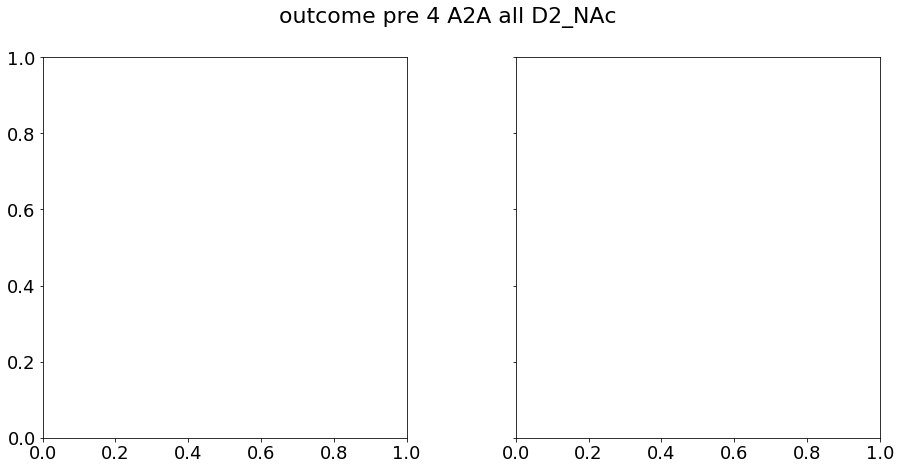

In [22]:
## Periswitch
beh_arg = 'outcome'
#beh_arg = 'side_out'
cond_arg = 'pre'
pre, post = -4, 4
# SOME animal are extremely stay-aversive
#animal, session = 'D1', 'all'
animal, session = 'A2A', 'all'
#animal, session = "A2A-15B-B_RT", "p153_FP_LH"
periswitch_mixed_outcome(giant_eventFP_mat, animal, session, pre, post, beh_arg, cond_arg, signal, ylims=(-2.2, 2.7))
# for animal in all_sessions:
#     for session in all_sessions[animal]:
#         periswitch_mixed_outcome(animal, session, pre, post, beh_arg, cond_arg, signal, ylims=(-2.2, 2.7))



(226, 957)
(251, 957)


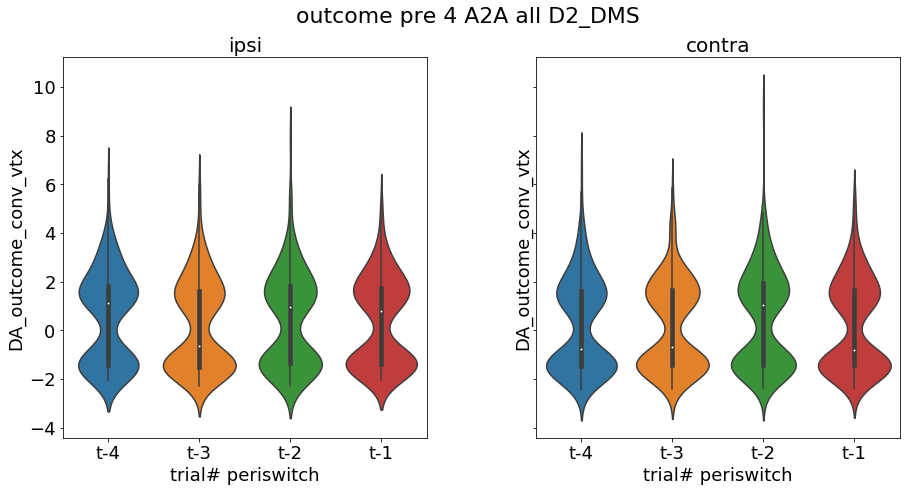

In [35]:
## Periswitch
beh_arg = 'outcome'
#beh_arg = 'side_out'
cond_arg = 'pre'
pre, post = -4, 4
# SOME animal are extremely stay-aversive
#animal, session = 'D1', 'all'
animal, session = 'A2A', 'all'
region = 'DMS'
signal = 'DA'
plot_out = f"/Users/albertqu/Documents/7.Research/Wilbrecht_Lab/CADA_plots/FP_{region}_D1D2_CADA/belief_state/avg"
#animal, session = "A2A-15B-B_RT", "p153_FP_LH"
periswitch_mixed_outcome(A2A_DMS_geFPM, animal, session, pre, post, beh_arg, cond_arg, signal, ylims=(-2.2, 2.7), plot_type='dimr_conv_vtx')
# for animal in all_sessions:
#     for session in all_sessions[animal]:
#         periswitch_mixed_outcome(giant_eventFP_mat, animal, session, pre, post, beh_arg, cond_arg, signal, 
#                                  ylims=(-2.2, 2.7), plot_type='dimr_pca_2')



(63, 953)
(61, 953)


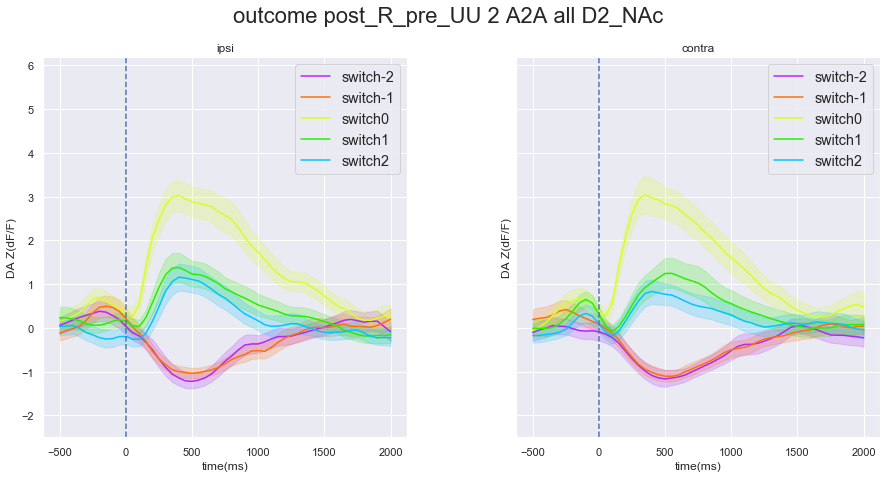

In [335]:
# Post switch after UU

#animal, session = 'D1', 'all'
animal, session = 'A2A', 'all'
#animal, session = "A2A-15B-B_RT", "p153_FP_LH"

beh_arg = 'outcome'
#beh_arg = 'side_out'
cond_arg = 'post_R_pre_UU'
pre, post = -2, 2
postUU_switch(giant_eventFP_mat, animal, session, pre, post, beh_arg, cond_arg, signal, ylims=(-2.5, 6.2))
# for animal in all_sessions:
#     for session in all_sessions[animal]:
#         postUU_switch(animal, session, pre, post, beh_arg, cond_arg, signal, ylims=(-2.5, 6.2))

(77, 958)
(89, 958)


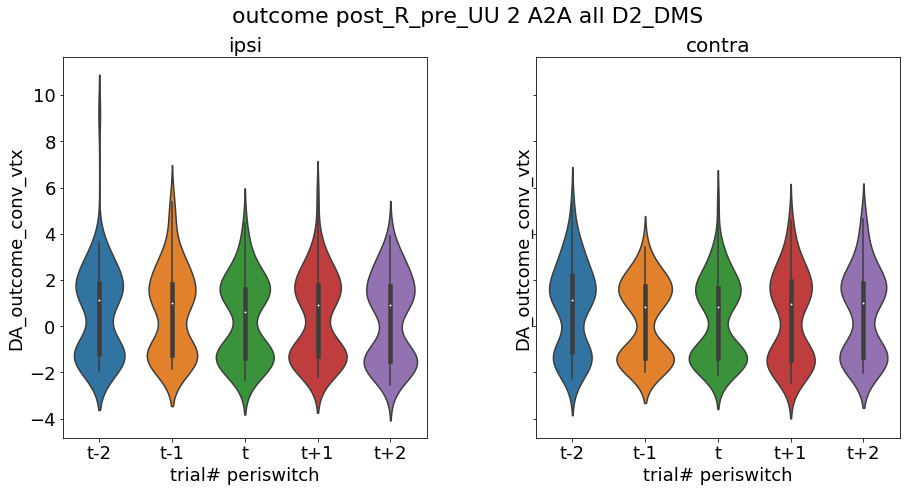

In [39]:
# Post switch after UU

#animal, session = 'D1', 'all'
animal, session = 'A2A', 'all'
region = 'DMS'
signal = 'DA'
plot_out = f"/Users/albertqu/Documents/7.Research/Wilbrecht_Lab/CADA_plots/FP_{region}_D1D2_CADA/belief_state/avg"
#animal, session = "A2A-15B-B_RT", "p153_FP_LH"

beh_arg = 'outcome'
#beh_arg = 'side_out'
cond_arg = 'post_R_pre_UU'
pre, post = -2, 2
postUU_switch(A2A_DMS_geFPM, animal, session, pre, post, beh_arg, cond_arg, signal, ylims=(-2.5, 6.2), 
              plot_type='dimr_conv_vtx')
# for animal in all_sessions:
#     for session in all_sessions[animal]:
#         postUU_switch(giant_eventFP_mat, animal, session, pre, post, beh_arg, cond_arg, signal, 
#                       ylims=(-2.5, 6.2), plot_type='dimr_pca_2')

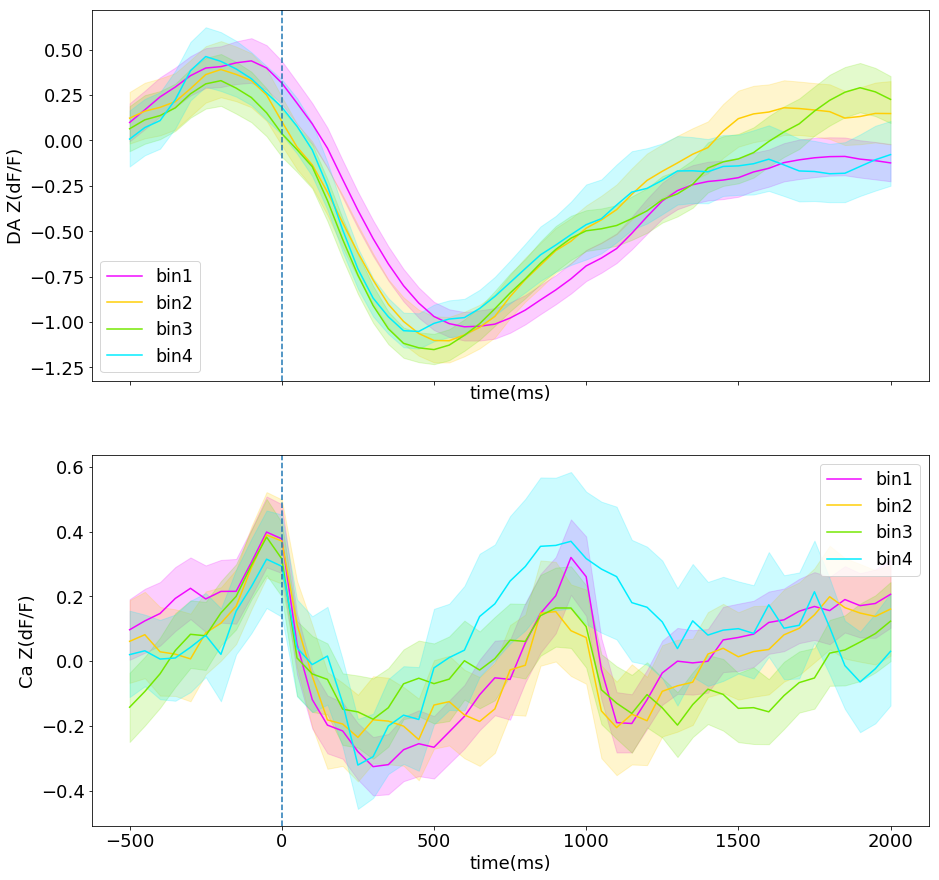

In [22]:
## RRstay or UUstay
fmat0 = drop_empty_nan(giant_eventFP_mat)
#animal, session = 'D1', 'all'
#animal, session = 'all', 'all'
animal, session = "A2A", 'all'
event_arg = 'outcome{t-1}'
beh_arg = event_arg.split('{')[0]
#action_arg = 'A{t-1}'
action_arg = 'A{t-1}'
if len(animal) > 3:
    fmat0 = fmat0[fmat0['animal'] == animal]
if session != 'all':
    fmat0 = fmat0[fmat0['session'] == session]
logsel = (fmat0['R{t-1}'] == 'U') & (
    fmat0['R{t-2}'] == 'U') & (fmat0['A{t-1}'] == fmat0['A{t-2}'])
# logsel = (fmat0['R{t-1}'] == 'R') & (
#     fmat0['R{t-2}'] == 'R') & (fmat0['A{t-1}'] == fmat0['A{t-2}'])
#color_series = ['b', 'c', 'g', 'k']
#color_series = ['r', 'm', 'tab:brown', 'k']
#cond_arg = 'UUstay_splitnext'
cond_arg = 'UUstay'
fmat_plot = fmat0[logsel]
all_bins = [f'bin{i}' for i in range(1, 5)]
if 'split' in cond_arg:
    if 'next' in cond_arg:
        fig, axes = plt.subplots(nrows=4, ncols=2, sharex=True, sharey='col', figsize=(15, 15))
        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        for i, sig in enumerate(['DA', 'Ca']):
            column_sel = get_columns_FP_df(fmat_plot, sig+f'_{event_arg}')
            for j, next_arg in enumerate(['ipsi_stay', 'ipsi_switch', 'contra_stay', 'contra_switch']):
                side, next_act = next_arg.split('_')
                if next_act == 'stay':
                    side_mat = fmat_plot[(fmat_plot[action_arg] == fmat_plot['A']) & 
                                         (fmat_plot[action_arg] == side)]
                else:
                    side_mat = fmat_plot[(fmat_plot[action_arg] != fmat_plot['A']) &
                                         (fmat_plot[action_arg] == side)]
                sub_traces = [side_mat.loc[side_mat['MVT_binN'] == bb, column_sel].values for bb in all_bins]
                peristimulus_time_trial_average_plot(sub_traces, time_window_dict[beh_arg], 
                                            tags=(None, 'time(ms)', f'{next_arg} Z(dF/F)', all_bins), 
                                                     ax=axes[j, i])
                axes[j, i].legend(fontsize='large')
                if j == 0:
                    axes[j, i].set_title(sig)
    else:
        fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey='row', figsize=(15, 15))
        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        for i, sig in enumerate(['DA', 'Ca']):
            column_sel = get_columns_FP_df(fmat_plot, sig+f'_{event_arg}')
            for j, side in enumerate(['ipsi', 'contra']):
                side_mat = fmat_plot[fmat_plot[action_arg] == side]
                sub_traces = [side_mat.loc[side_mat['MVT_binN'] == bb, column_sel].values for bb in all_bins]
                peristimulus_time_trial_average_plot(sub_traces, time_window_dict[beh_arg], 
                                            tags=(None, 'time(ms)', f'{sig} Z(dF/F)', all_bins), 
                                                     ax=axes[i, j])
                axes[i, j].legend(fontsize='large')
                if i == 0:
                    axes[i, j].set_title(side)
else:
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey='row', figsize=(15, 15))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    for i, sig in enumerate(['DA', 'Ca']):
        column_sel = get_columns_FP_df(fmat_plot, sig+f'_{event_arg}')
        side_mat = fmat_plot
        sub_traces = [side_mat.loc[side_mat['MVT_binN'] == bb, column_sel].values for bb in all_bins]
        peristimulus_time_trial_average_plot(sub_traces, time_window_dict[beh_arg], 
                                    tags=(None, 'time(ms)', f'{sig} Z(dF/F)', all_bins), ax=axes[i])
        #axes[i, j].legend(fontsize='large')
        axes[i].legend(fontsize='xx-large')
plt.subplots_adjust(hspace=0.2, wspace=0.2)
# subipsi = fmat_plot.loc[fmat_plot['A{t-1}'] == 'ipsi', column_sel]
# subcontra = fmat_plot.loc[fmat_plot['A{t-1}'] == 'contra', column_sel]
plt.savefig(os.path.join(plot_out, f'DACa_{event_arg}_MVT_bin_{cond_arg}_{animal}_{session}_CI.png'))
# TODO: compare the movement time differences across stay vs switch
# TODO: different event FP comparison 

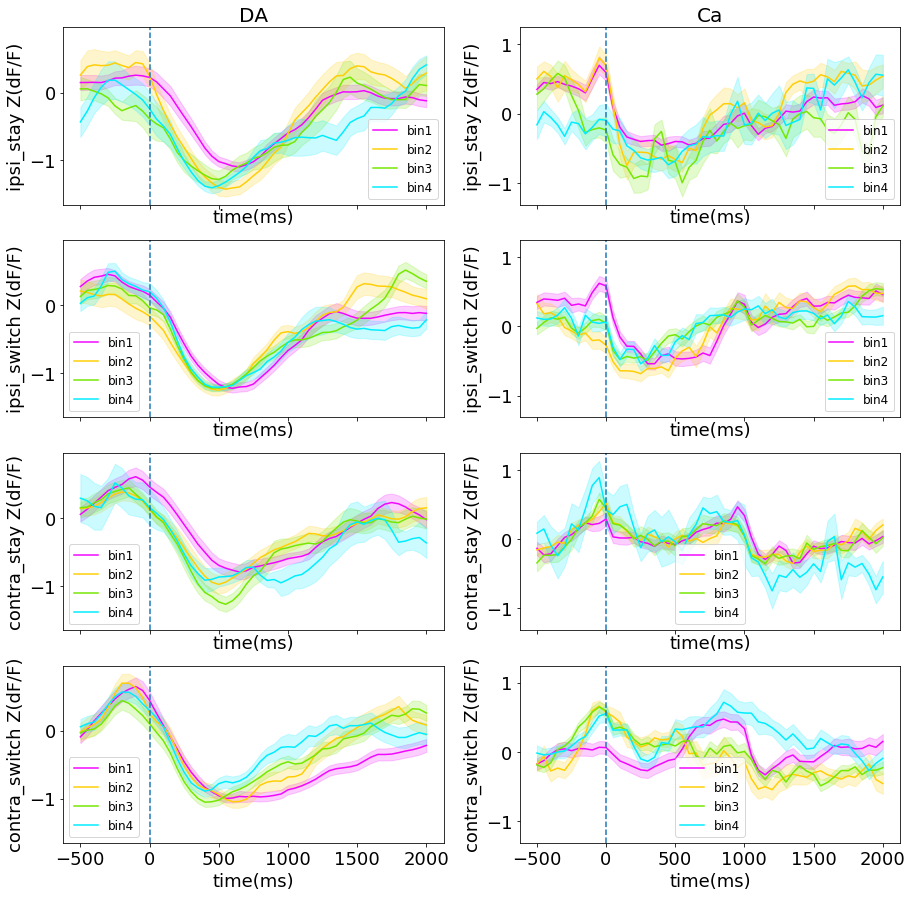

In [21]:
## UU 
fmat0 = drop_empty_nan(giant_eventFP_mat)
animal, session = 'D1', 'all'
#animal, session = 'all', 'all'
#animal, session = "A2A-15B-B_RT", "p153_FP_LH"
event_arg = 'outcome{t-1}'
beh_arg = event_arg.split('{')[0]
#action_arg = 'A{t-1}'
action_arg = 'A{t-1}'
if len(animal) > 3:
    fmat0 = fmat0[fmat0['animal'] == animal]
if session != 'all':
    fmat0 = fmat0[fmat0['session'] == session]
logsel = (fmat0['R{t-1}'] == 'U') & (
    fmat0['R{t-2}'] == 'U') & (fmat0['A{t-1}'] == fmat0['A{t-2}'])
#color_series = ['b', 'c', 'g', 'k']
#color_series = ['r', 'm', 'tab:brown', 'k']
cond_arg = 'UUstay_splitnext'
fmat_plot = fmat0[logsel]
all_bins = [f'bin{i}' for i in range(1, 5)]
if 'split' in cond_arg:
    if 'next' in cond_arg:
        fig, axes = plt.subplots(nrows=4, ncols=2, sharex=True, sharey='col', figsize=(15, 15))
        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        for i, sig in enumerate(['DA', 'Ca']):
            column_sel = get_columns_FP_df(fmat_plot, sig+f'_{event_arg}')
            for j, next_arg in enumerate(['ipsi_stay', 'ipsi_switch', 'contra_stay', 'contra_switch']):
                side, next_act = next_arg.split('_')
                if next_act == 'stay':
                    side_mat = fmat_plot[(fmat_plot[action_arg] == fmat_plot['A']) & 
                                         (fmat_plot[action_arg] == side)]
                else:
                    side_mat = fmat_plot[(fmat_plot[action_arg] != fmat_plot['A']) &
                                         (fmat_plot[action_arg] == side)]
                sub_traces = [side_mat.loc[side_mat['MVT_binN'] == bb, column_sel].values for bb in all_bins]
                peristimulus_time_trial_average_plot(sub_traces, time_window_dict[beh_arg], 
                                            tags=(None, 'time(ms)', f'{next_arg} Z(dF/F)', all_bins), 
                                                     ax=axes[j, i])
                axes[j, i].legend(fontsize='large')
                if j == 0:
                    axes[j, i].set_title(sig)
    else:
        fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey='row', figsize=(15, 15))
        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        for i, sig in enumerate(['DA', 'Ca']):
            column_sel = get_columns_FP_df(fmat_plot, sig+f'_{event_arg}')
            for j, side in enumerate(['ipsi', 'contra']):
                side_mat = fmat_plot[fmat_plot[action_arg] == side]
                sub_traces = [side_mat.loc[side_mat['MVT_binN'] == bb, column_sel].values for bb in all_bins]
                peristimulus_time_trial_average_plot(sub_traces, time_window_dict[beh_arg], 
                                            tags=(None, 'time(ms)', f'{sig} Z(dF/F)', all_bins), 
                                                     ax=axes[i, j])
                axes[i, j].legend(fontsize='large')
                if i == 0:
                    axes[i, j].set_title(side)
else:
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey='row', figsize=(15, 15))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    for i, sig in enumerate(['DA', 'Ca']):
        column_sel = get_columns_FP_df(fmat_plot, sig+f'_{event_arg}')
        side_mat = fmat_plot
        sub_traces = [side_mat.loc[side_mat['MVT_binN'] == bb, column_sel].values for bb in all_bins]
        peristimulus_time_trial_average_plot(sub_traces, time_window_dict[beh_arg], 
                                    tags=(None, 'time(ms)', f'{sig} Z(dF/F)', all_bins), ax=axes[i])
        #axes[i, j].legend(fontsize='large')
        axes[i].legend(fontsize='xx-large')
plt.subplots_adjust(hspace=0.2, wspace=0.2)
# subipsi = fmat_plot.loc[fmat_plot['A{t-1}'] == 'ipsi', column_sel]
# subcontra = fmat_plot.loc[fmat_plot['A{t-1}'] == 'contra', column_sel]
plt.savefig(os.path.join(plot_out, f'DACa_{event_arg}_MVT_bin_{cond_arg}_{animal}_{session}.png'))
# TODO: compare the movement time differences across stay vs switch
# TODO: different event FP comparison 

NAc iSPN high pred accuracy: try to see if dSPN is the same

In [ ]:
#
#from sklearn.linear_model import TweedieRegressor
#reg = TweedieRegressor(power=1, alpha=0.5, link='log')

In [12]:
def visualize_model_sub_event_accuracy(eventFP_mat, behavior_arg, window_sel_arg, lag_arg, ncomp_args,
                                       dep_arg, plot_out=None):
    fast_map = {'A2A': 'iSPN', 'D1': 'dSPN'}
    indiv_scores = [None] * 2

    RRstay_sel = eventFP_mat[(eventFP_mat['R{t-1}'] == 'R') & (eventFP_mat['R{t-2}'] == 'R')
                       & (eventFP_mat['A{t-1}'] == eventFP_mat['A{t-2}'])]
    UUstay_sel = eventFP_mat[(eventFP_mat['R{t-1}'] == 'U') & (eventFP_mat['R{t-2}'] == 'U')
                             & (eventFP_mat['A{t-1}'] == eventFP_mat['A{t-2}'])]

    subevent_sels = [RRstay_sel, UUstay_sel]
    for i, ssels in enumerate(subevent_sels):
        log_model_choice, Xlog, ylog, fmat0, best_score = decode_neural_to_behavior(ssels,
                                                                                    (behavior_arg,
                                                                                     window_sel_arg,
                                                                                     lag_arg,
                                                                                     ncomp_args), dep_arg)
        indiv_scores[i] = best_score

    neur_types = np.unique([barg.split('_')[0] for barg in behavior_arg]).astype('<U5')
    
    if 'Ca' in neur_types:
        neur_types[neur_types == 'Ca'] = fast_map[eventFP_mat['animal'].values[0].split('-')[0]]
    neur_type_arg = '_'.join(neur_types)
    animals = np.unique(eventFP_mat['animal'])
    all_sessions = np.unique(eventFP_mat['session'])
    region = eventFP_mat['region'].values[0]
    print(animals, all_sessions, eventFP_mat['animal'].values[0].split('-')[0] + f'_{region}')
    if (len(animals) > 1) or (len(all_sessions) > 1):
        animal = eventFP_mat['animal'].values[0].split('-')[0] + f'_{region}'
        session = 'multisession'
    else:
        animal, session = eventFP_mat['animal'].values[0], eventFP_mat['session'].values[0]

    xlabels = ['RR stay', 'UU stay']

    dep = {'A': 'Choice', 'MVT_bin': 'Movement Times Bins', 'MVT_binN': 'Movement Time Quartiles'}[dep_arg[0]]

    ntrial = -np.min(lag_arg)
    mean_scores = np.mean(indiv_scores, axis=0)
    all_normal = True
    for im in range(2):
        stat, pv = shapiro(indiv_scores[im])
        if pv > 0.05:
            all_normal = False
    Kmeas = len(indiv_scores[0])
    plt.figure(figsize=(10, 8))
    wholeDF = pd.DataFrame({'type': np.repeat(xlabels, Kmeas),
                            'Decoder Accuracy': np.ravel(indiv_scores, order='C')})
    sns.barplot(x='type', y='Decoder Accuracy', data=wholeDF, ci=95)
    plt.ylim((0, 0.9))
    # plt.bar(np.arange(3), mean_scores, yerr=std_scores)
    # plt.xticks(np.arange(3), xlabels)
    # plt.xlabel('type')
    # plt.ylabel('Decoder Accuracy')
    # TODO: Generalize
    plt.title(f'Comparison of {region} {neur_type_arg} {dep} Predictions with \n   \n'
              f'Outcome Phase {ntrial} back')
    if plot_out is not None:
        plt.savefig(os.path.join(plot_out, f'decoder_subevent_comp_{neur_type_arg}_{ntrial}_{dep.lower()}_'
        f'{animal}_{session}'))
    return wholeDF


In [65]:
#DAosel0 = (time_window_dict['outcome']>=500) & (time_window_dict['outcome']<=1500)
DAosel0 = (time_window_dict['outcome'] <= 1500)
Caosel0 = time_window_dict['outcome'] <= 1500

behavior_arg = ['Ca_outcome']
window_sel_arg = [Caosel0]
lag_arg = [[-1, -2, -3, -4]]
ncomp_args = [7]
dep_arg = ['A', 'contra']
#dep_arg = ['MVT_binN', None]
# Xlog, ylog = pd.concat(Xlog, axis=1), (fmat0['A{t-1}'] == 'contra').astype(np.int)
# Xlog, ylog = pd.concat(Xlog, axis=1), fmat0['MVT_bin']

log_model_choice, Xlog, ylog, fmat0, best_score= decode_neural_to_behavior(giant_eventFP_mat, (behavior_arg, 
                                                           window_sel_arg, lag_arg, ncomp_args), dep_arg)
logsel = (fmat0['R{t-1}'] == 'U') & (fmat0['R{t-2}'] == 'U') & (fmat0['A{t-1}'] == fmat0['A{t-2}'])


In [44]:
np.mean(best_score)

0.7607846715328468

['A2A-15B-B_RT' 'A2A-19B_RT' 'A2A-19B_RV'] ['p139_FP_LH' 'p142_FP_RH' 'p148_FP_LH' 'p153_FP_LH' 'p238_FP_LH'] A2A_NAc


,type,Decoder Accuracy
0,RR stay,0.844538
1,RR stay,0.844538
2,RR stay,0.840336
3,RR stay,0.844538
4,RR stay,0.806723
...,...,...
195,UU stay,0.666667
196,UU stay,0.666667
197,UU stay,0.592593
198,UU stay,0.574074


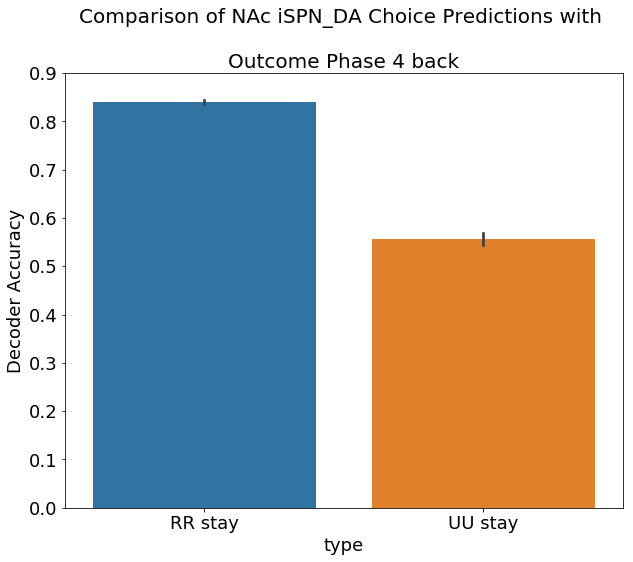

In [71]:
behavior_arg = ['Ca_outcome', 'DA_outcome']
window_sel_arg = [Caosel0, DAosel0]
lag_arg = [[-1, -2, -3, -4], [-1, -2, -3, -4]]
ncomp_args = [7, 7]
visualize_model_sub_event_accuracy(giant_eventFP_mat, behavior_arg, window_sel_arg, lag_arg, ncomp_args, 
                                   dep_arg, plot_out)

['A2A-15B-B_RT' 'A2A-16B-1_RT' 'A2A-16B-1_TT'] ['p147_FP_RH' 'p151_session1_FP_RH' 'p151_session2_FP_RH' 'p156_FP_RH'
 'p220_FP_RH' 'p221_FP_RH' 'p222_FP_LH' 'p232_FP_RH'] A2A_DMS


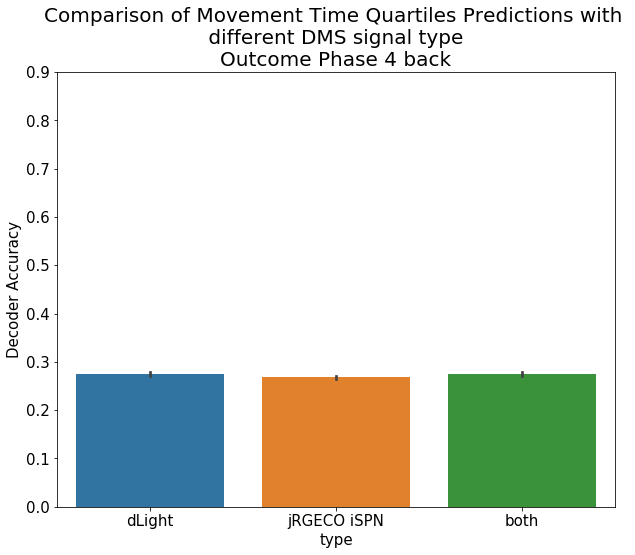

In [30]:
window_sel_arg_cp = [DAosel0, Caosel0]
lag_arg_cp = [[-1, -2, -3, -4], [-1, -2, -3, -4]]
ncomp_args_cp = [7, 7]
#dep_arg_cp = ['A', 'contra']
#dep_arg_cp = ['MVT_binN', None]
accu = visualize_model_accuracy(giant_eventFP_mat, window_sel_arg_cp, lag_arg_cp, ncomp_args_cp, dep_arg_cp, plot_out)

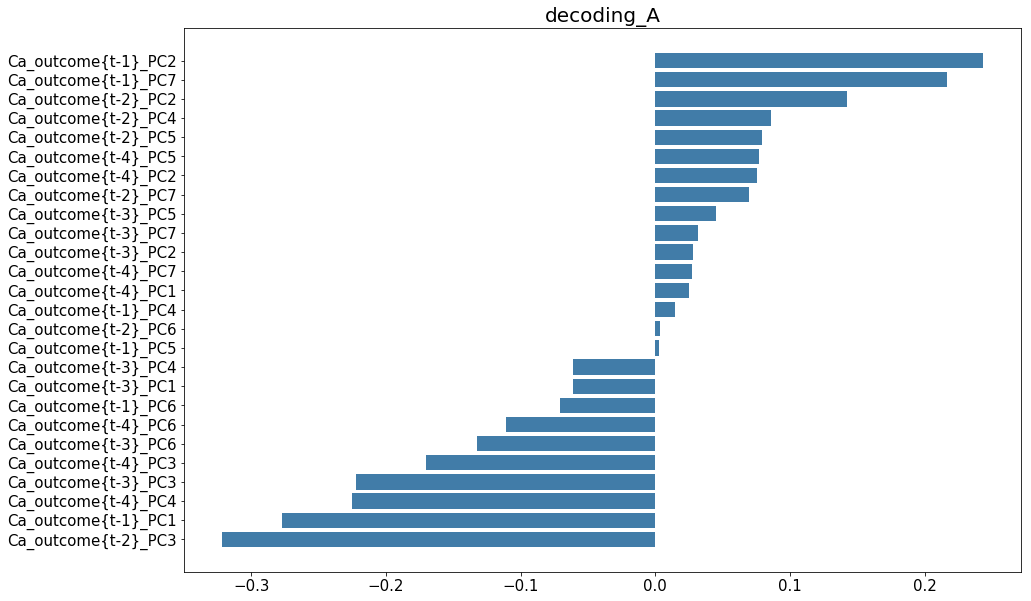

In [77]:
visualize_feature_weights_decoder(giant_eventFP_mat, plot_out)

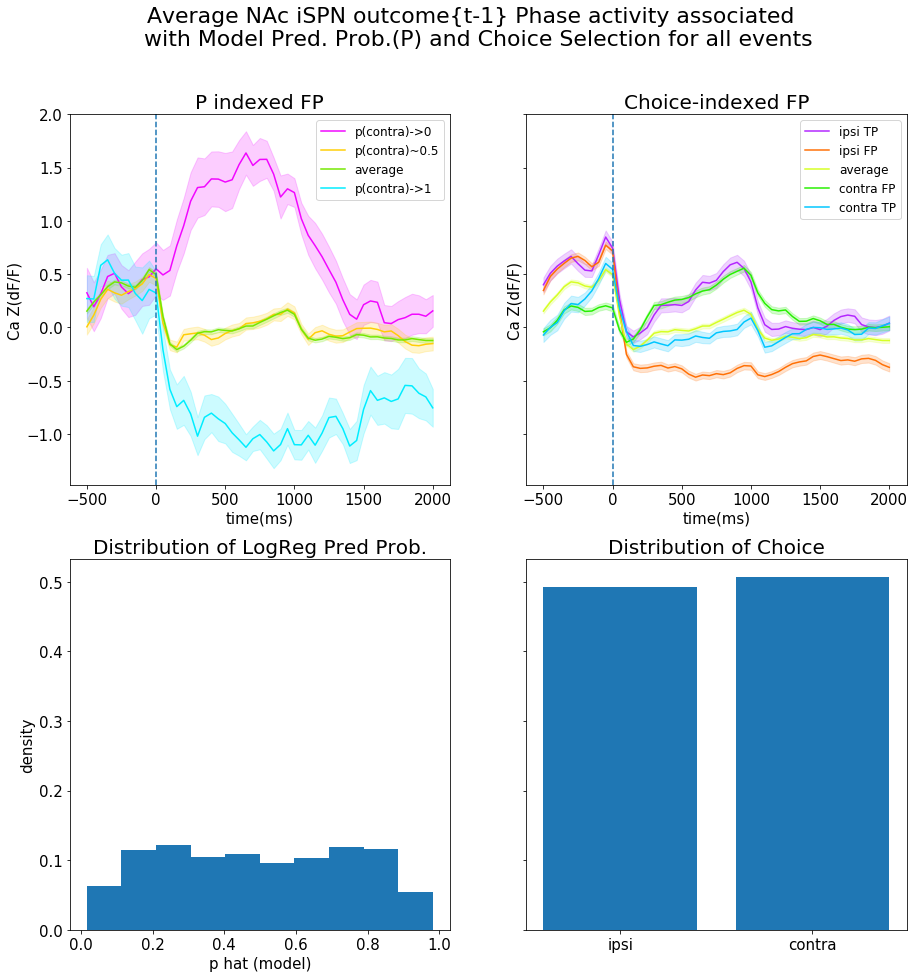

In [36]:
stayside, switchside = 'ipsi', 'contra'
behavior_arg = "outcome{t-1}"
dependent = 'A'
feature_sel = (fmat0['animal'] == animal)
select_tag = 'all'
hemi_map = {'LH': {'ipsi': 'left', 'contra': 'right'},
            'RH': {'ipsi': 'right', 'contra': 'left'}}[session.split('_')[-1]]
sum_trial = np.sum(feature_sel)
pred_prob = log_model_choice.predict_proba(Xlog)[:, 0]
bound_sel = np.abs(pred_prob - 0.5) <= 0.05
bound_upper_sel = (1 - pred_prob) <= 0.05
bound_lower_sel = pred_prob <= 0.05
sig = 'Ca'
fast_map = {'A2A': 'iSPN', 'D1': 'dSPN'}
if sig == 'Ca':
    fp_type = fast_map[animal.split('-')[0]]
else:
    fp_type = sig
acols = get_columns_FP_df(fmat0, sig+'_' +behavior_arg)
fig, axes = plt.subplots(nrows=2, ncols=2, sharey='row', figsize=(15, 15))
fl = fmat0.loc[bound_lower_sel & feature_sel, acols].values
fu = fmat0.loc[bound_upper_sel&feature_sel, acols].values
f0 = fmat0.loc[bound_sel&feature_sel, acols].values
fm = fmat0[feature_sel][acols].values
peristimulus_time_trial_average_plot([fl, f0, fm, fu], time_window_dict[behavior_arg.split('{')[0]],
                                         tags=(None, 'time(ms)', f'{sig} Z(dF/F)', 
                                               ['p(contra)->0', 'p(contra)~0.5', 'average', 'p(contra)->1']), 
                                     ax=axes[0, 0])
axes[0, 0].legend(fontsize='large')
axes[0, 0].set_title('P indexed FP')
axes[1, 0].hist(pred_prob[feature_sel], weights=np.full(sum_trial, 1/sum_trial))
axes[1, 0].set_xlabel('p hat (model)')
axes[1, 0].set_title('Distribution of LogReg Pred Prob.')
axes[1, 0].set_ylabel('density')

ipsi_sel = feature_sel & (fmat0['A'] == 'ipsi')
contra_sel = feature_sel & (fmat0['A'] == 'contra')
fctfp = fmat0.loc[contra_sel & (pred_prob < 0.5), acols].values
fipfp = fmat0.loc[ipsi_sel & (pred_prob >= 0.5), acols].values
fcttp = fmat0.loc[contra_sel & (pred_prob >= 0.5), acols].values
fiptp = fmat0.loc[ipsi_sel & (pred_prob < 0.5), acols].values
#print(fct.shape, fip.shape, fcttp.shape, fiptp.shape)

peristimulus_time_trial_average_plot([fiptp, fipfp, fm, fctfp, fcttp], time_window_dict['outcome'],
                                         tags=(None, 'time(ms)', f'{sig} Z(dF/F)', 
                                               ['ipsi TP', 'ipsi FP', 
                                                'average', 'contra FP', 'contra TP']), ax=axes[0, 1])
axes[0, 1].legend(fontsize='large')
axes[0, 1].set_title('Choice-indexed FP')
axes[1, 1].bar([0, 1], [np.sum(ipsi_sel) / sum_trial, np.sum(contra_sel) / sum_trial])
axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_xticklabels(['ipsi', 'contra'])
axes[1, 1].set_title('Distribution of Choice')
region_val = fmat0["region"].values[0]
fig.suptitle(f'Average {region_val} {fp_type} ' + behavior_arg + 
             f' Phase activity associated \n with Model Pred. Prob.(P) and Choice Selection for {select_tag} events')
# fig.savefig(os.path.join(plot_out, 
#                          f'logreg_p_{behavior_arg}_{dependent}_{sig}_indexing_{select_tag}_{animal}_{session}.png'))
fig.savefig(os.path.join(plot_out, 
                         f'logreg_p_{behavior_arg}_{dependent}_{sig}_indexing_{select_tag}_all.png'))

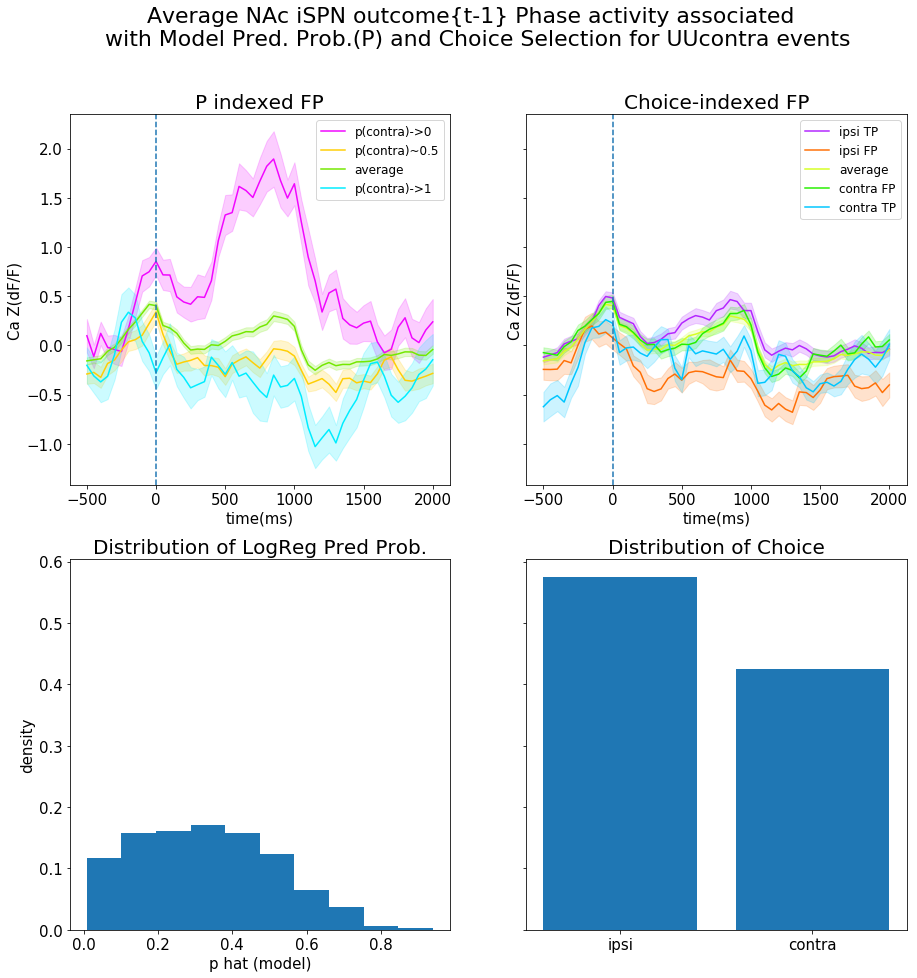

In [39]:
# stayside, switchside = 'ipsi', 'contra'
stayside, switchside = 'contra', 'ipsi'
behavior_arg = "outcome{t-1}"
dependent = 'A'
feature_sel = (fmat0['R{t-1}'] == 'U') & (fmat0['R{t-2}'] == 'U') & (
    fmat0['A{t-1}'] == fmat0['A{t-2}']) & (fmat0['A{t-1}'] == stayside)
select_tag = f'UU{stayside}'
hemi_map = {'LH': {'ipsi': 'left', 'contra': 'right'},
            'RH': {'ipsi': 'right', 'contra': 'left'}}[session.split('_')[-1]]
sum_trial = np.sum(feature_sel)
pred_prob = log_model_choice.predict_proba(Xlog)[:, 0]
bound_sel = np.abs(pred_prob - 0.5) <= 0.05
#bound_upper_sel = (1 - pred_prob) <= 0.1
bound_upper_sel = (1 - pred_prob) <= 0.3
#bound_lower_sel = pred_prob <= 0.4
bound_lower_sel = pred_prob <= 0.05
sig = 'Ca'
fast_map = {'A2A': 'iSPN', 'D1': 'dSPN'}
if sig == 'Ca':
    fp_type = fast_map[animal.split('-')[0]]
else:
    fp_type = sig
acols = get_columns_FP_df(fmat0, sig+'_' +behavior_arg)
fig, axes = plt.subplots(nrows=2, ncols=2, sharey='row', figsize=(15, 15))
fl = fmat0.loc[bound_lower_sel & feature_sel, acols].values
fu = fmat0.loc[bound_upper_sel&feature_sel, acols].values
f0 = fmat0.loc[bound_sel&feature_sel, acols].values
fm = fmat0[feature_sel][acols].values
peristimulus_time_trial_average_plot([fl, f0, fm, fu], time_window_dict[behavior_arg.split('{')[0]],
                                         tags=(None, 'time(ms)', f'{sig} Z(dF/F)', 
                                               ['p(contra)->0', 'p(contra)~0.5', 'average', 'p(contra)->1']), 
                                     ax=axes[0, 0])
axes[0, 0].legend(fontsize='large')
axes[0, 0].set_title('P indexed FP')
axes[1, 0].hist(pred_prob[feature_sel], weights=np.full(sum_trial, 1/sum_trial))
axes[1, 0].set_xlabel('p hat (model)')
axes[1, 0].set_title('Distribution of LogReg Pred Prob.')
axes[1, 0].set_ylabel('density')

ipsi_sel = feature_sel & (fmat0['A'] == 'ipsi')
contra_sel = feature_sel & (fmat0['A'] == 'contra')
fctfp = fmat0.loc[contra_sel & (pred_prob < 0.5), acols].values
fipfp = fmat0.loc[ipsi_sel & (pred_prob >= 0.5), acols].values
fcttp = fmat0.loc[contra_sel & (pred_prob >= 0.5), acols].values
fiptp = fmat0.loc[ipsi_sel & (pred_prob < 0.5), acols].values
#print(fct.shape, fip.shape, fcttp.shape, fiptp.shape)

peristimulus_time_trial_average_plot([fiptp, fipfp, fm, fctfp, fcttp], time_window_dict['outcome'],
                                         tags=(None, 'time(ms)', f'{sig} Z(dF/F)', 
                                               ['ipsi TP', 'ipsi FP', 
                                                'average', 'contra FP', 'contra TP']), ax=axes[0, 1])
axes[0, 1].legend(fontsize='large')
axes[0, 1].set_title('Choice-indexed FP')
axes[1, 1].bar([0, 1], [np.sum(ipsi_sel) / sum_trial, np.sum(contra_sel) / sum_trial])
axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_xticklabels(['ipsi', 'contra'])
axes[1, 1].set_title('Distribution of Choice')
region_val = fmat0["region"].values[0]
fig.suptitle(f'Average {region_val} {fp_type} ' + behavior_arg + 
             f' Phase activity associated \n with Model Pred. Prob.(P) and Choice Selection for {select_tag} events')
fig.savefig(os.path.join(plot_out, 
                         f'logreg_p_{behavior_arg}_{dependent}_{sig}_indexing_{select_tag}_all.png'))

[Text(0, 0, 'ipsi'), Text(0, 0, 'contra')]

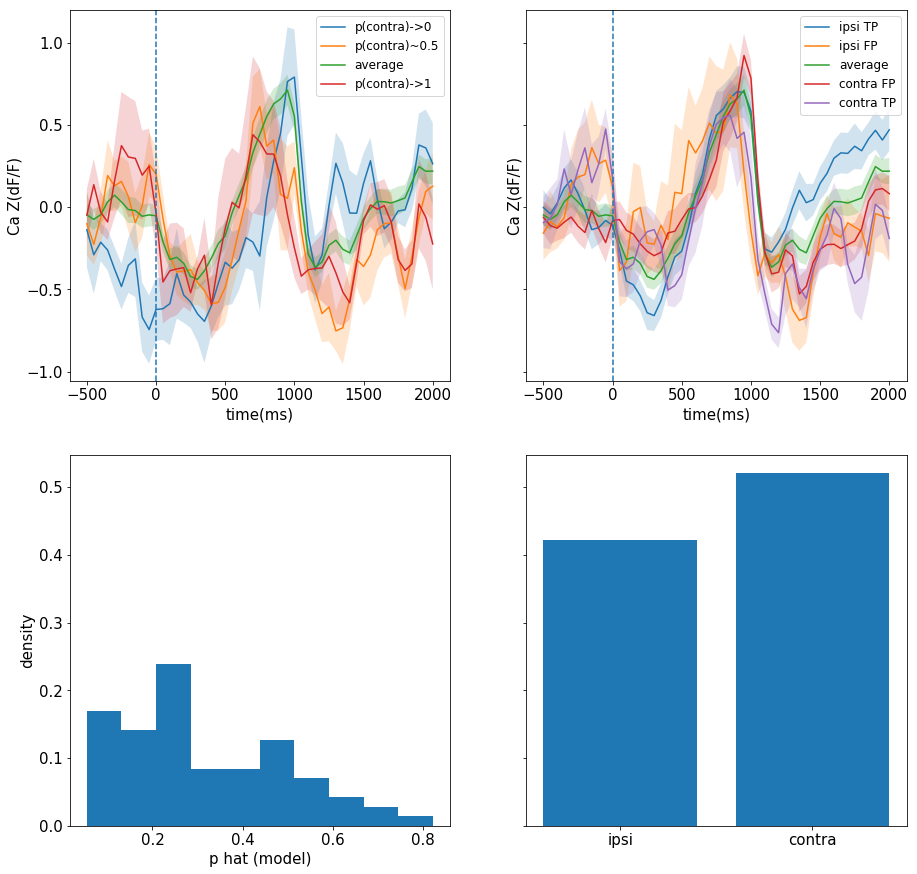

In [110]:
stayside, switchside = 'contra', 'ipsi'
feature_sel = (fmat0['R{t-1}'] == 'U') & (fmat0['R{t-2}'] == 'U') & (
    fmat0['A{t-1}'] == fmat0['A{t-2}']) & (fmat0['A{t-1}'] == stayside)
sum_trial = np.sum(feature_sel)
pred_prob = log_model_choice.predict_proba(Xlog)[:, 0]
bound_sel = np.abs(pred_prob - 0.5) <= 0.05
bound_upper_sel = (1 - pred_prob) <= 0.4
bound_lower_sel = pred_prob <= 0.1
sig = 'Ca'
acols = get_columns_FP_df(fmat0, sig+'_outcome{t-1}')
fig, axes = plt.subplots(nrows=2, ncols=2, sharey='row', figsize=(15, 15))
fl = fmat0.loc[bound_lower_sel & feature_sel, acols].values
fu = fmat0.loc[bound_upper_sel&feature_sel, acols].values
f0 = fmat0.loc[bound_sel&feature_sel, acols].values
fm = fmat0[feature_sel][acols].values
peristimulus_time_trial_average_plot([fl, f0, fm, fu], time_window_dict['outcome'],
                                         tags=(None, 'time(ms)', 
                                               f'{sig} Z(dF/F)', ['p(contra)->0', 'p(contra)~0.5', 'average', 'p(contra)->1']), ax=axes[0, 0])
axes[0, 0].legend(fontsize='large')
axes[1, 0].hist(pred_prob[feature_sel], weights=np.full(sum_trial, 1/sum_trial))
axes[1, 0].set_xlabel('p hat (model)')
axes[1, 0].set_ylabel('density')

ipsi_sel = feature_sel & (fmat0['A'] == 'ipsi')
contra_sel = feature_sel & (fmat0['A'] == 'contra')
fctfp = fmat0.loc[contra_sel & (pred_prob < 0.5), acols].values
fipfp = fmat0.loc[ipsi_sel & (pred_prob > 0.5), acols].values
fcttp = fmat0.loc[contra_sel & (pred_prob > 0.5), acols].values
fiptp = fmat0.loc[ipsi_sel & (pred_prob < 0.5), acols].values
#print(fct.shape, fip.shape, fcttp.shape, fiptp.shape)

peristimulus_time_trial_average_plot([fiptp, fipfp, fm, fctfp, fcttp], time_window_dict['outcome'],
                                         tags=(None, 'time(ms)', 
                                               f'{sig} Z(dF/F)', ['ipsi TP', 'ipsi FP', 'average', 'contra FP', 'contra TP']), ax=axes[0, 1])
axes[0, 1].legend(fontsize='large')
axes[1, 1].bar([0, 1], [len(fst) / sum_trial, len(fsw) / sum_trial])
axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_xticklabels(['ipsi', 'contra'])


In [304]:
ylogsel = log_model_choice.predict(Xlog.values[logsel])
print('accu', log_model_choice.score(Xlog.values[logsel], ylog.values[logsel]))
bili = pd.DataFrame({'pred': ylogsel, 'truth': ylog[logsel], 
                     'A{t-1}': fmat0.loc[logsel, 'A{t-1}'], 'A{t-2}': fmat0.loc[logsel, 'A{t-2}']})
bili

accu 0.5259259259259259


,pred,truth,A{t-1},A{t-2}
12,0,1,contra,contra
13,1,1,contra,contra
16,1,0,contra,contra
27,0,1,contra,contra
39,1,0,contra,contra
...,...,...,...,...
991,0,1,ipsi,ipsi
993,0,0,contra,contra
998,0,0,ipsi,ipsi
999,0,1,ipsi,ipsi


Text(0.5, 1.0, 'decoding_A')

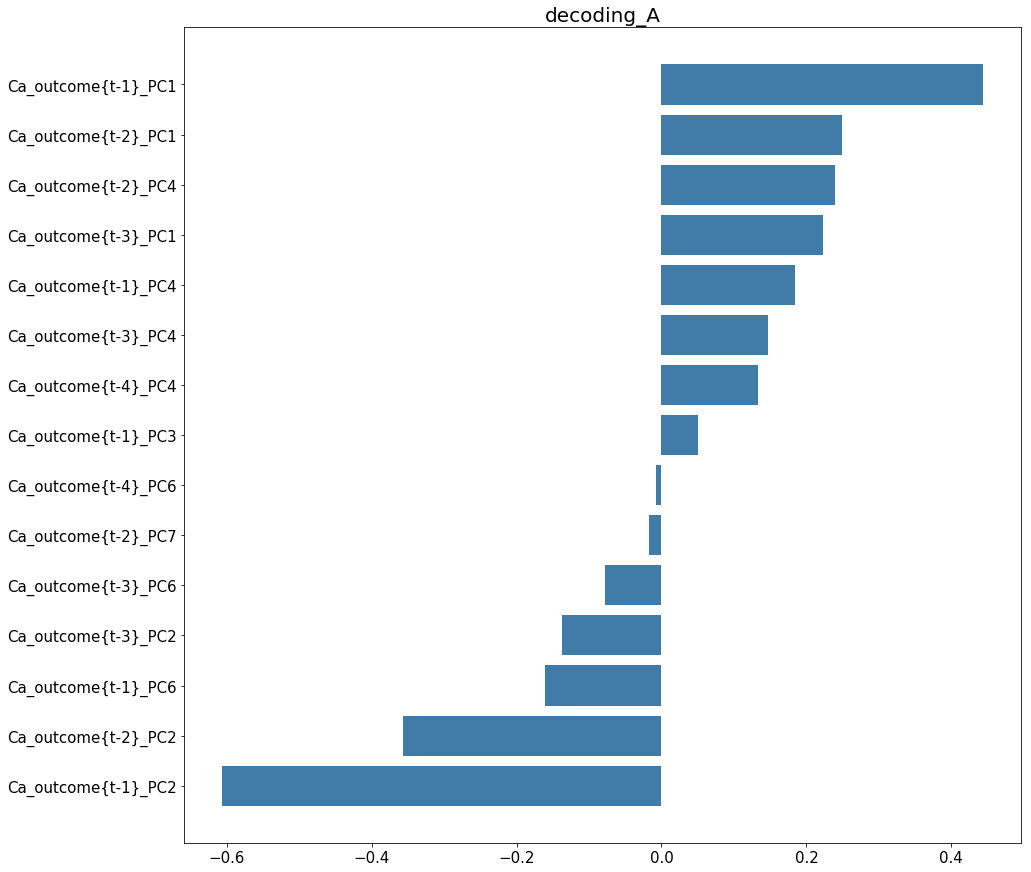

In [149]:
betas = log_model_choice.coef_[0, :]
visualize_weights(betas, Xlog.columns)
plt.title(f'decoding_{ylog.name}')

### Prediction Accuracy for ITI is relatively low, slightly above chance (~0.3) 
-> better performance with Unreward reward separate

In [226]:
# Compare Detailed delta_accuracy with removing one feature
# calibrated_forest = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators=50))
# param_grid = {'base_estimator__max_depth': np.arange(2, 20, 2)}
# rand_inds = np.arange(Xlog.shape[0])
# np.random.shuffle(rand_inds)
random_forest = RandomForestClassifier(n_estimators=50)
param_grid = {'max_depth': np.arange(2, 20, 2)}
#search = GridSearchCV(calibrated_forest, param_grid, cv=5).fit(Xlog, ylog)
search_model = GridSearchCV(random_forest, param_grid, cv=5).fit(Xlog, ylog)
(search_model.score(Xlog, ylog), search_model.best_score_)

(1.0, 0.7727699530516432)

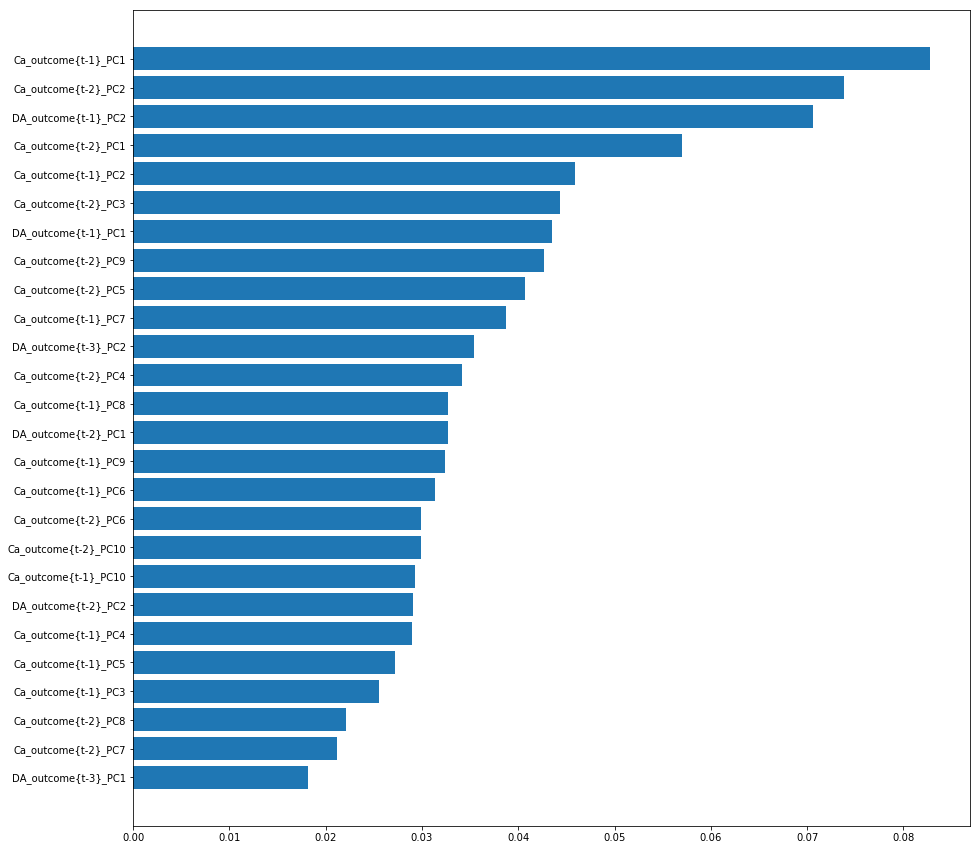

In [426]:
visualize_weights(search_model.best_estimator_.feature_importances_, Xlog.columns, 0.01)

In [227]:
search_model.score(Xlog.values[logsel], ylog[logsel])

1.0

## Deprecated

### Test of dim reduction method

Text(0, 0.5, 'Percentage Rewarded')

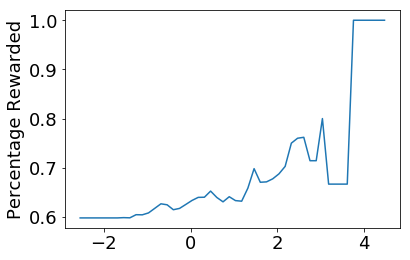

In [185]:
Xlog, pca = eventFP_mat_dimred(fmat0, eventsig, windowsels[sig], ncomp=3, returnPCA=True)
XlogAUC = eventFP_mat_dimred(fmat0, eventsig, windowsels[sig], ncomp='mean', returnPCA=False)
allrange = Xlog.values[:, 0].ravel()
#allrange = XlogAUC.values.ravel()
xs = np.linspace(np.min(allrange)-1, np.max(allrange)-0.1, 50)
ys = [fmat0[allrange > x]['R'].value_counts()[0] / np.sum(fmat0[allrange > x]['R'].value_counts()) for x in xs]
plt.plot(xs, ys)
plt.ylabel('Percentage Rewarded')

Text(0.5, 1.0, 'AUC0,1500')

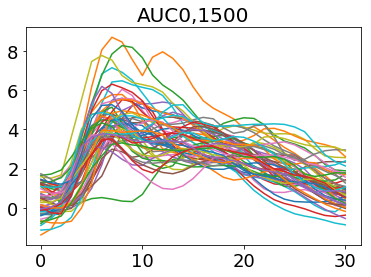

In [151]:
V=plt.plot(fp_select[XlogAUC.values.ravel()>2].T)
plt.title('AUC0,1500')

Text(0.5, 1.0, 'PCA1')

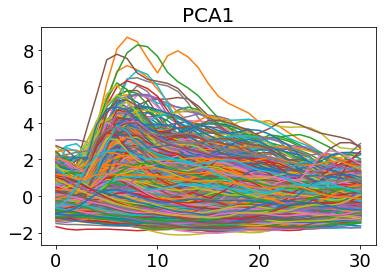

In [160]:
V=plt.plot(fp_select[Xlog.values[:, 1].ravel()< 2].T)
plt.title('PCA1')

Text(0, 0.5, 'AUC')

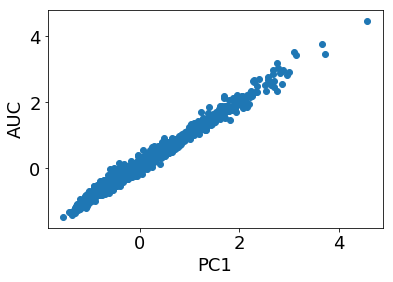

In [56]:
plt.scatter(Xlog, XlogAUC)
plt.xlabel('PC1')
plt.ylabel('AUC')

In [17]:
zscore=True
base_method='robust_fast'
denoise=True

time_window_dict = {'center_in': np.arange(-500, 501, 50),
                    'center_out': np.arange(-500, 501, 50),
                    'outcome': np.arange(-500, 2001, 50),
                    'side_out': np.arange(-500, 1001, 50)}
tags = ['DA', 'Ca']
fit_models = ['RandomForests']

files = encode_to_filename(folder, animal, session, ['green', 'red', 'FP', 'behavior_old', 'processed'])
matfile, green, red, fp = files['behavior_old'], files['green'], files['red'], files['FP']
# Load FP
if fp is not None:
    with h5py.File(fp, 'r') as fp_hdf5:
        fp_sigs = [access_mat_with_path(fp_hdf5, f'{tags[i]}/dff/{base_method}')
                   for i in range(len(tags))]
        if zscore:
            fp_sigs = [(fp_sigs[i] - np.mean(fp_sigs[i])) / np.std(fp_sigs[i], ddof=1)
                       for i in range(len(fp_sigs))]
        fp_times = [access_mat_with_path(fp_hdf5, f'{tags[i]}/time') for i in
                    range(len(tags))]
else:
    print(f"Warning {animal} {session} does not have photometry processed!")
    fp_times, fp_sigs, iso_times, iso_sigs = get_sources_from_csvs([green, red],
                                                                   tags=('DA', 'Ca'), show=False)

    fp_sigs = [raw_fluor_to_dff(fp_times[i], fp_sigs[i], iso_times[i], iso_sigs[i], base_method,
                                zscore=zscore) for i in range(len(fp_sigs))]
if denoise:
    L = len(fp_times)
    new_times, new_sigs = [None] * L, [None] * L
    for i in range(L):
        new_sigs[i], new_times[i] = denoise_quasi_uniform(fp_sigs[i], fp_times[i])
    fp_sigs, fp_times = new_sigs, new_times
    # TODO: for now just do plots for one session

mat = h5py.File(matfile, 'r')
event_types = ['center_in{t-1}', 'center_in', 'center_out{t-1}', 'center_out', 'outcome{t-2}', 'outcome{t-1}', 'outcome', 'side_out{t-1}']
trial_feature = "A"
# Get aligned signals to behaviors
aligned = [[] for _ in range(len(fp_sigs))]
behavior_times = np.vstack([get_behavior_times_old(mat, beh) for beh in event_types])
nonan_sel = ~np.any(np.isnan(behavior_times), axis=0)
behavior_times_nonan = behavior_times[:, nonan_sel]
behavior_time_map = {event_types[i]: i for i in range(len(behavior_times))}
for ib, beh in enumerate(event_types):
    # TODO: ADD caps for multiple behavior time latencies
    for i in range(len(fp_sigs)):
        aligned[i].append(align_activities_with_event(fp_sigs[i], fp_times[i], behavior_times_nonan[ib],
                                                      time_window_dict[beh.split('{')[0]], False))

In [9]:
# calculate ITI:
rf = get_trial_features_old(mat, 'R', as_array=True)
rew_outcome = array_to_feature_sels(trial_vector_time_lag(rf, -1))
#rew_outcome = get_trial_features_old(mat, 'R', False)
mvmt_times = behavior_times[behavior_time_map['center_in']] - behavior_times[behavior_time_map['side_out{t-1}']]
mvmt_nonan = ~np.isnan(mvmt_times)
rew_mvmts = mvmt_times[mvmt_nonan & rew_outcome['Rewarded']]
unrew_mvmts = mvmt_times[mvmt_nonan & rew_outcome['Unrewarded']]
rew_bins = list(np.percentile(rew_mvmts, [25, 50, 75])) + [4000]
unrew_bins = list(np.percentile(unrew_mvmts, [25, 50, 75])) + [4000]
rew_mvmts_nonan = mvmt_times[nonan_sel & rew_outcome['Rewarded']]
unrew_mvmts_nonan = mvmt_times[nonan_sel & rew_outcome['Unrewarded']]
unrew_bin1 = unrew_mvmts_nonan <= unrew_bins[0] 
unrew_bin2 = (unrew_bins[0] < unrew_mvmts_nonan) & (unrew_mvmts_nonan<= unrew_bins[1])
unrew_bin3 = (unrew_bins[1] < unrew_mvmts_nonan) & (unrew_mvmts_nonan<= unrew_bins[2]) 
unrew_bin4 = (unrew_bins[2] < unrew_mvmts_nonan) & (unrew_mvmts_nonan<= unrew_bins[3])
# plt.figure(figsize=(20, 15))
# plt.subplot(211)
# plt.hist(mvmt_times[mvmt_nonan & rew_outcome['Rewarded']], density=True, range=(0, 4000))
# plt.title('rewarded')
# plt.subplot(212)
# plt.hist(mvmt_times[mvmt_nonan & rew_outcome['Unrewarded']], density=True, range=(0, 4000))
# plt.title('unrewarded')

In [10]:
dfmat = aligned_FP_to_df(mat, fp_sigs, fp_times, 
                         ['outcome{t}', 'outcome{t-1}', 'outcome{t-2}', 'outcome{t-3}', 'outcome{t-4}'], 
                         time_window_dict)
full_rew_bins = [0] + rew_bins
rew_intervals = [(int(full_rew_bins[i]), int(full_rew_bins[i+1])) for i in range(len(full_rew_bins)-1)]
rew_intervals_tags = [str(itvl) for itvl in rew_intervals]
rew_iti_bins = [(mvmt_times > itvl[0]) & (mvmt_times <= itvl[1]) & rew_outcome['Rewarded'] for itvl in rew_intervals]
full_unrew_bins = [0] + unrew_bins
unrew_intervals = [(int(full_unrew_bins[i]), int(full_unrew_bins[i+1])) for i in range(len(full_unrew_bins)-1)]
unrew_intervals_tags = [str(itvl) for itvl in unrew_intervals]
unrew_iti_bins = [(mvmt_times > itvl[0]) & (mvmt_times <= itvl[1]) & rew_outcome['Unrewarded'] for itvl in unrew_intervals]
ITI_bin_array = feature_sels_to_array(rew_intervals_tags+unrew_intervals_tags, 
                                      np.vstack([rew_iti_bins, unrew_iti_bins]))
binnums = [f'bin{ib}' for ib in range(1, len(rew_intervals)+1)]
ITI_bin_num_array = feature_sels_to_array(binnums+binnums, 
                                      np.vstack([rew_iti_bins, unrew_iti_bins]))
all_features = ['R{t-2}', 'R{t-1}', 'A{t-2}', 'A{t-1}']
fmaps = {'R': {'Rewarded': 'R', 'Unrewarded': 'U', '': ''}}
rew_feature = get_trial_features_old(mat, 'R', as_array=True)
side_feature = get_trial_features_old(mat, 'A', as_array=True)
data = np.vstack([trial_vector_time_lag(rew_feature, -2), trial_vector_time_lag(rew_feature, -1),
                  trial_vector_time_lag(side_feature, -2), trial_vector_time_lag(side_feature, -1)]).T
feature_mat = pd.DataFrame(data, columns=all_features)
feature_mat['R'] = rew_feature
feature_mat['A'] = side_feature
for ff in ['R', 'R{t-1}', 'R{t-2}']:
    feature_mat = map_feature_to_alias(feature_mat, fmaps[ff.split('{')[0]], ff)
feature_mat = merge_features(feature_mat, all_features)
feature_mat['MVT_bin'] = ITI_bin_array
feature_mat['MVT_binN'] = ITI_bin_num_array
feature_mat['MVT'] = mvmt_times
header_mat = pd.DataFrame({'trial': np.arange(get_trial_num(mat))})
header_mat['animal'], header_mat['session'] = animal, session
eventFP_mat2 = pd.concat([header_mat, feature_mat, dfmat], axis=1)
eventFP_mat2[5:10]

/anaconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

invalid value encountered in greater

/anaconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

invalid value encountered in less_equal

/anaconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning:

invalid value encountered in greater

/anaconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning:

invalid value encountered in less_equal



In [349]:
unrew_intervals_tags

['(0, 459)', '(459, 593)', '(593, 1111)', '(1111, 4000)']

In [9]:
rew_intervals_tags

['(0, 435)', '(435, 486)', '(486, 570)', '(570, 4000)']

In [10]:
print(behavior_time_map)

{'center_in{t-1}': 0, 'center_in': 1, 'center_out{t-1}': 2, 'center_out': 3, 'outcome{t-2}': 4, 'outcome{t-1}': 5, 'outcome': 6, 'side_out{t-1}': 7}


[0.62941919 0.10492065]
[0.19878556 0.1610779 ]


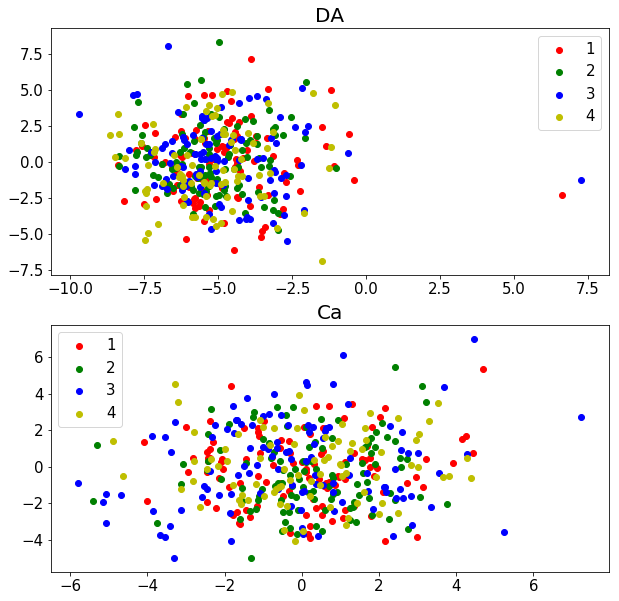

In [39]:
# Excellent Pipeline to compare ITI bin neur activity (neur:ITI)
event_arg = 'outcome{t-1}'
fig, axes=plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
for i, sig in enumerate(['DA', 'Ca']):
    fluors_mat = aligned[i][behavior_time_map[event_arg]]
    twindow = time_window_dict[event_arg.split('{')[0]]
    #window_sel = (twindow >= 500) & (twindow <= 1500)
    window_sel = twindow >=-1000
    fluors_pca = fluors_mat[:, window_sel]
    pca = PCA(n_components=2)
    transforms = pca.fit_transform(fluors_pca)
    print(pca.explained_variance_ratio_)
    rew_sel = rew_outcome['Rewarded'][nonan_sel]
    unrew_sel = rew_outcome['Unrewarded'][nonan_sel]
    #print(transforms.shape, rew_sel.shape)
    
#     axes[i].scatter(transforms[rew_sel][:, 0], transforms[rew_sel][:, 1], c='g')
#     axes[i].scatter(transforms[unrew_sel][:, 0], transforms[unrew_sel][:, 1], c='r')
    axes[i].scatter(transforms[unrew_sel][unrew_bin1][:, 0], transforms[unrew_sel][unrew_bin1][:, 1], c='r')
    axes[i].scatter(transforms[unrew_sel][unrew_bin2][:, 0], transforms[unrew_sel][unrew_bin2][:, 1], c='g')
    axes[i].scatter(transforms[unrew_sel][unrew_bin3][:, 0], transforms[unrew_sel][unrew_bin3][:, 1], c='b')
    axes[i].scatter(transforms[unrew_sel][unrew_bin4][:, 0], transforms[unrew_sel][unrew_bin4][:, 1], c='y')
    axes[i].legend(['1', '2', '3', '4'])
    #axes[i].legend(['R', 'UR'])
    axes[i].set_title(sig)
#fig.savefig('pca.png')

In [ ]:
# #rew_feature = 
# rews, unrews = rew_feature['Rewarded'], rew_feature['Unrewarded']
# ipsis, contras = lat_feature['ipsi'], lat_feature['contra'].astype(np.float)
# # contra: 1, ipsi: -1
# rew_lat = np.vstack([rews * (contras - ipsis), unrews * (contras - ipsis)])
# rewlat_labels = np.concatenate([['rew_lat{t-%d}' % i, 'unrew_lat{t-%d}' % i] for i in range(1, lag+1)])
# Xlags = lagmat(rew_lat.T, maxlag=lag, trim="both", original='ex')

{'A2A-15B-B_RT': ['p153_FP_LH', 'p238_FP_LH'],
 'A2A-19B_RT': ['p139_FP_LH', 'p148_FP_LH'],
 'A2A-19B_RV': ['p142_FP_RH']}

In [7]:
eventFP_mat = animal_session_to_event_mat(folder, animal, session, region, rew_bins, unrew_bins)
eventFP_mat[5:10]

/anaconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:100: RuntimeWarning:

invalid value encountered in greater

/anaconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:100: RuntimeWarning:

invalid value encountered in less_equal

/anaconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning:

invalid value encountered in greater

/anaconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning:

invalid value encountered in less_equal



,trial,animal,session,region,R{t-2},R{t-1},A{t-2},A{t-1},R,A,...,Ca_outcome{t-4}(1550),Ca_outcome{t-4}(1600),Ca_outcome{t-4}(1650),Ca_outcome{t-4}(1700),Ca_outcome{t-4}(1750),Ca_outcome{t-4}(1800),Ca_outcome{t-4}(1850),Ca_outcome{t-4}(1900),Ca_outcome{t-4}(1950),Ca_outcome{t-4}(2000)
5,5,A2A-15B-B_RT,p153_FP_LH,NAc,R,R,ipsi,ipsi,U,contra,...,-0.504854,-1.026096,-1.500685,-1.467235,-1.231711,-1.490900,-2.197399,-1.774171,-1.518430,-1.647991
6,6,A2A-15B-B_RT,p153_FP_LH,NAc,R,U,ipsi,contra,U,ipsi,...,-1.153274,-1.643202,-1.824520,-1.872165,-1.895755,-1.818376,-1.684061,-1.641088,-1.583097,-1.596324
7,7,A2A-15B-B_RT,p153_FP_LH,NAc,U,U,contra,ipsi,R,ipsi,...,0.523646,-0.003875,-0.587452,-0.685788,-0.244703,-0.198435,-0.476555,-0.761845,-0.725953,-0.405576
8,8,A2A-15B-B_RT,p153_FP_LH,NAc,U,R,ipsi,ipsi,R,ipsi,...,-0.615695,-0.916464,-0.947943,-0.929744,-0.738996,-0.814652,-0.973544,-1.158766,-1.495875,-0.748691
9,9,A2A-15B-B_RT,p153_FP_LH,NAc,R,R,ipsi,ipsi,U,ipsi,...,0.029831,-0.213597,-0.398494,-0.286148,-0.225232,-0.002849,0.061415,0.319202,0.223392,0.349399


In [8]:
print('fraction long ITI:', feature_mat[(feature_mat['MVT_bin'] == '') & (feature_mat['R{t-1}'] == 'U')]
      .shape[0]/np.sum(feature_mat['R{t-1}'] =='U'))

NameError: name 'feature_mat' is not defined

['Ca_outcome{t-1}(-500)' 'Ca_outcome{t-1}(-450)' 'Ca_outcome{t-1}(-400)'
 'Ca_outcome{t-1}(-350)' 'Ca_outcome{t-1}(-300)' 'Ca_outcome{t-1}(-250)'
 'Ca_outcome{t-1}(-200)' 'Ca_outcome{t-1}(-150)' 'Ca_outcome{t-1}(-100)'
 'Ca_outcome{t-1}(-50)' 'Ca_outcome{t-1}(0)' 'Ca_outcome{t-1}(50)'
 'Ca_outcome{t-1}(100)' 'Ca_outcome{t-1}(150)' 'Ca_outcome{t-1}(200)'
 'Ca_outcome{t-1}(250)' 'Ca_outcome{t-1}(300)' 'Ca_outcome{t-1}(350)'
 'Ca_outcome{t-1}(400)' 'Ca_outcome{t-1}(450)' 'Ca_outcome{t-1}(500)'
 'Ca_outcome{t-1}(550)' 'Ca_outcome{t-1}(600)' 'Ca_outcome{t-1}(650)'
 'Ca_outcome{t-1}(700)' 'Ca_outcome{t-1}(750)' 'Ca_outcome{t-1}(800)'
 'Ca_outcome{t-1}(850)' 'Ca_outcome{t-1}(900)' 'Ca_outcome{t-1}(950)'
 'Ca_outcome{t-1}(1000)' 'Ca_outcome{t-1}(1050)' 'Ca_outcome{t-1}(1100)'
 'Ca_outcome{t-1}(1150)' 'Ca_outcome{t-1}(1200)' 'Ca_outcome{t-1}(1250)'
 'Ca_outcome{t-1}(1300)' 'Ca_outcome{t-1}(1350)' 'Ca_outcome{t-1}(1400)'
 'Ca_outcome{t-1}(1450)' 'Ca_outcome{t-1}(1500)' 'Ca_outcome{t-1}(1550)'
 '

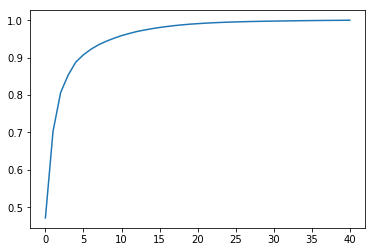

In [225]:
fmat0 = drop_empty_nan(eventFP_mat)
cacol1 = np.array(get_columns_FP_df(fmat0, 'Ca_outcome{t-1}'))
print(cacol1)
pca = PCA().fit(fmat0[cacol1[(time_window_dict['outcome']<=1500)]])
plt.plot(np.arange(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_))

#### ITI Detailed Split
* Observation: Past Choice Side has minimal impact on distribution, should further test dependencies with permutations tests

['' 'R_R_contra_contra' 'R_R_ipsi_contra' 'R_R_ipsi_ipsi'
 'R_U_contra_contra' 'R_U_contra_ipsi' 'R_U_ipsi_contra' 'R_U_ipsi_ipsi'
 'U_R_contra_contra' 'U_R_contra_ipsi' 'U_R_ipsi_contra' 'U_R_ipsi_ipsi'
 'U_U_contra_contra' 'U_U_contra_ipsi' 'U_U_ipsi_contra' 'U_U_ipsi_ipsi']


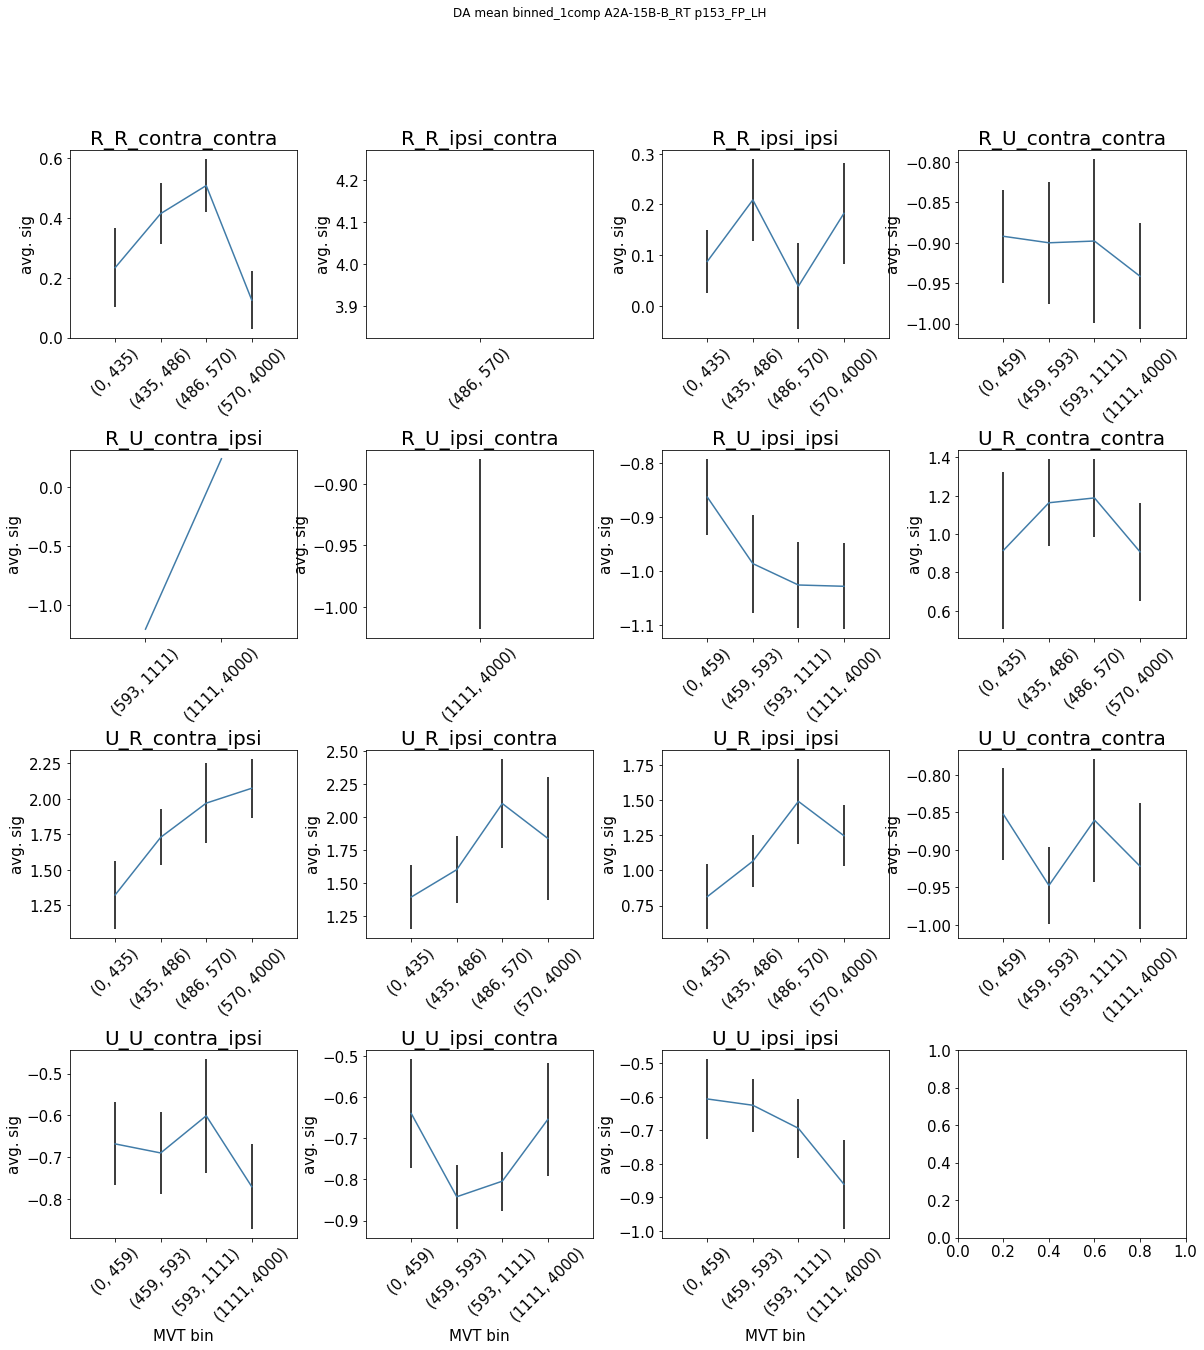

In [44]:
# Detailed split
# Deprecated: Need to use old DATA Structure
event_arg = 'outcome{t-1}'
behavior_arg = event_arg.split('{')[0]
opt_feature = 'R{t-2}_R{t-1}_A{t-2}_A{t-1}'
hue_feature = 'MVT_bin'
#plot_type = 'binned'
#plot_type = 'scatter'
plot_type = 'binned_1comp'
sameXY = True
sig = 'DA'
ith = {'DA': 0, 'Ca': 1}[sig]
fluors_mat = aligned[ith][behavior_time_map[event_arg]]
twindow = time_window_dict[behavior_arg]
window_sel = (twindow >= 500) & (twindow <= 1500)
#dim_red, PC_sel = 'PCA', 0
dim_red, PC_sel = 'mean', 0
if plot_type == 'scatter' and sameXY:
    fig, axes=plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)
else:
    fig, axes=plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
axes = axes.ravel()

#window_sel = twindow >= 500
fluors_tf = fluors_mat[:, window_sel]
if dim_red == 'mean':
    transforms = np.mean(fluors_tf, axis=1, keepdims=True)
else:
    pca = PCA(n_components=2)
    transforms = pca.fit_transform(fluors_tf)
    print(pca.explained_variance_ratio_)
opts = np.unique(eventFP_mat[opt_feature])
print(opts)
opts = opts[opts != '']
for j in range(len(opts)):
    opt_sel = (eventFP_mat[opt_feature] == opts[j])
    #opt_sel = feature_mat['R{t-1}'] == ('U' if (j % 2 == 0) else 'R')
    if plot_type == 'binned':
        assert dim_red == 'PCA'
        hue_bins = ITI_bin_sort(np.unique(eventFP_mat[opt_sel]['MVT_bin']))
        #colors = sns.diverging_palette(240, 10, n=len(hue_bins))
        #colors = sns.color_palette("icefire", len(hue_bins))
        colors = ['b', 'g', 'y', 'r']
        for hh, hhue in enumerate(hue_bins):
            selected = transforms[((eventFP_mat['MVT_bin'] == hhue) & opt_sel)[nonan_sel]]
            axes[j].scatter(selected[:, 0], selected[:, 1], color=colors[hh], label=hhue)
        axes[j].legend()
        if j >= ((np.ceil(len(opts) / 4)-1) * 4):
            axes[j].set_xlabel('PC1')
        axes[j].set_ylabel('PC2')
        axes[j].set_title(opts[j])
    elif plot_type == 'scatter':
        jmv_nonan = ~np.isnan(eventFP_mat['MVT'])
        curr_sel = (jmv_nonan & opt_sel)[nonan_sel]
        mvt_data = eventFP_mat['MVT'][nonan_sel][curr_sel]
        neural_data = transforms[curr_sel, PC_sel]
        axes[j].scatter(mvt_data, neural_data)
        if max(mvt_data) > 4000:
            axes[j].set_xlim((0, 4000))
            if j >= ((np.ceil(len(opts) / 4)-1) * 4):
                axes[j].set_xlabel('MVT(ms) (cutoff at 4s)')
        else:
            if j >= ((np.ceil(len(opts) / 4)-1) * 4):
                axes[j].set_xlabel('MVT(ms)')
        if dim_red == 'mean':
            axes[j].set_ylabel(f'avg. sig')
        else:
            axes[j].set_ylabel(f'PC{PC_sel+1}')
        sp_stats, sp_p = spearmanr(mvt_data, neural_data)
        axes[j].set_title(opts[j] + f' N={len(mvt_data)}\nR={sp_stats:.2f} p={sp_p:.4f}')
    elif plot_type == 'binned_1comp':
        colors = sns.diverging_palette(240, 10, n=2)
        hue_bins = ITI_bin_sort(np.unique(eventFP_mat[opt_sel]['MVT_bin']))
        mean_trace = np.empty(len(hue_bins))
        std_trace = np.empty(len(hue_bins))
        for hh, hhue in enumerate(hue_bins):
            selected = transforms[((eventFP_mat['MVT_bin'] == hhue) & opt_sel)[nonan_sel], PC_sel]
            mean_trace[hh] = np.mean(selected)
            std_trace[hh] = np.std(selected) / np.sqrt(len(selected))
        xs = np.arange(len(hue_bins))
        if len(hue_bins):
            axes[j].errorbar(xs, mean_trace, yerr=std_trace, c=colors[ith], ecolor='k')
        axes[j].set_xticks(xs)
        axes[j].set_xticklabels(hue_bins, rotation=45)
        axes[j].set_xlim([-1, len(hue_bins)])
        if j >= ((np.ceil(len(opts) / 4)-1) * 4):
            axes[j].set_xlabel('MVT bin')
        if dim_red == 'mean':
            axes[j].set_ylabel(f'avg. sig')
        else:
            axes[j].set_ylabel(f'PC{PC_sel+1}')
        axes[j].set_title(opts[j])
    
plt.subplots_adjust(hspace=0.6, wspace=0.3)
fig.suptitle(f"{sig} {dim_red} {plot_type} {animal} {session}")
fig.savefig(os.path.join(plot_out, f'{sig}_RA2t_ITI_{dim_red}_{plot_type}_{animal}_{session}.png'))

#### Advanced ANOVA
DA: less lateral information
Ca: rich lateral information

In [619]:
DAosel0 = (time_window_dict['outcome']>=500) & (time_window_dict['outcome']<=1500)
Caosel0 = time_window_dict['outcome']<= 1500
Caosel1 = time_window_dict['outcome']<= 50
twindow_sels = {'DA_outcome{t-1}': DAosel0,
               'DA_outcome{t-2}': DAosel0,
               'DA_outcome{t-3}': DAosel0,
               'DA_outcome{t-4}': DAosel0,
               'Ca_outcome{t-1}': Caosel0,
               'Ca_outcome{t-2}': Caosel0,
               'Ca_outcome{t-3}': Caosel0,
               'Ca_outcome{t-4}': Caosel0}
eventFP_mat_clean = drop_empty_nan(eventFP_mat)
dred_mat_DA = eventFP_mat_dimred(eventFP_mat_clean, 'DA_outcome{t-1}', DAosel0, 'mean')
dred_mat_Ca = eventFP_mat_dimred(eventFP_mat_clean, 'Ca_outcome{t-1}', Caosel1, 'mean')
eFP_anova = pd.DataFrame(eventFP_mat_clean[['R{t-2}', 'R{t-1}', 'A{t-2}','A{t-1}', 'MVT']].values, 
                         columns=['R2back','R1back', 'A2back','A1back', 'MVT'])
eFP_anova['DA_1back_mean'], eFP_anova['Ca_1back_mean'] = dred_mat_DA, dred_mat_Ca
eFP_anova['MVT'] = eFP_anova['MVT'].astype(np.float)
eFP_anova['MVT_binN'] = eventFP_mat_clean['MVT_binN']

In [586]:
eFP_anova

,R2back,R1back,A2back,A1back,MVT,DA_1back_mean,Ca_1back_mean,MVT_binN
0,R,R,ipsi,ipsi,339.003104,-0.780355,-0.693857,NaN
1,R,R,ipsi,ipsi,430.988846,-0.425774,-0.513631,NaN
2,R,U,ipsi,contra,2701.430086,-0.850702,0.196160,NaN
3,U,U,contra,ipsi,714.981496,-1.255559,-0.286701,NaN
4,U,R,ipsi,ipsi,625.506893,0.398436,-1.369162,bin1
...,...,...,...,...,...,...,...,...
1060,R,R,ipsi,ipsi,496.960354,0.369964,-0.418651,bin4
1061,R,R,ipsi,ipsi,484.491998,0.476121,0.268157,bin4
1062,R,R,ipsi,ipsi,2527.385512,0.235248,-0.272021,bin3
1063,R,R,ipsi,ipsi,500.015439,0.569843,0.349320,bin1


In [635]:
# No significant contributions of MVT
# Time to fish around in MVT
# DA Ca interaction
# Yet MVT_bin has minute interactions with DA signal (increase explained variance)
import statsmodels.formula.api as smf
import patsy
import statsmodels.api as sm
#ftemp = 'DA_1back_mean ~ MVT'
#ftemp = 'DA_1back_mean ~ R1back * R2back * A1back * A2back * MVT_binN' # A1back * A2back
ftemp = 'Ca_1back_mean ~ A1back * A2back * R1back'
#ftemp = 'DA_1back_mean ~ R1back:R2back" + A1back:R1back + A2back:R2back + MVT_binN:R2back:R1back:A2back:A1back'
#ftemp = 'Ca_1back_mean ~ R2back*R1back*A1back*A2back*MVT' # A1back * A2back
#ftemp = 'DA_1back_mean ~ R2back:A2back + R1back:A1back + R2back:R1back + MVT' # A1back * A2back
#ytemp,Xtemp = patsy.dmatrices(ftemp, drop_empty_nan(feature_p), return_type='dataframe')
# #constant is by default supported
#res = sm.OLS(ytemp, Xtemp).fit()
res = smf.ols(formula=ftemp, data=eFP_anova).fit()
#eselss = (eFP_anova['R2back'] == 'U') & (eFP_anova['R1back'] == 'R') & (eFP_anova['A2back'] != eFP_anova['A1back'])
#res = smf.ols(formula=ftemp, data=eFP_anova[eselss]).fit()
#res = smf.ols(formula=ftemp, data=eFP_anova[(eFP_anova['R2back'] == 'U') & (eFP_anova['R1back'] == 'R')]).fit()
#res = smf.glm(formula=ftemp, data=drop_empty_nan(feature_p), family=sm.families.Gamma()).fit()
table = sm.stats.anova_lm(res, typ=2)
print(table)

                   sum_sq      df           F        PR(>F)
A1back         100.209718     1.0  493.260195  4.742471e-90
R1back           0.904891     1.0    4.454128  3.505053e-02
A1back:R1back    0.010313     1.0    0.050763  8.217847e-01
Residual       215.550559  1061.0         NaN           NaN


In [636]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Ca_1back_mean   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     165.1
Date:                Mon, 30 Nov 2020   Prob (F-statistic):           8.22e-88
Time:                        00:12:16   Log-Likelihood:                -660.48
No. Observations:                1065   AIC:                             1329.
Df Residuals:                    1061   BIC:                             1349.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.0084      0.025     -0.332      0.740      -0.058       0.041
A1back[T.ipsi]                 0.6088      0.035     17.189      0.000       0.539       0.678
R1back[T.U]                    0.0535      0.040      1.349      0.178      -0.024       0.131
A1back[T.ipsi]:R1back[T.U]     0.0128      0.057      0.225      0.822      -0.098       0.124
==============================================================================
Omnibus:                       43.635   Durbin-Watson:                   1.575
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.030
Skew:                           0.348   Prob(JB):                     1.69e-15
Kurtosis:                       4.024   Cond. No.                         6.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [491]:
eFP_anova[(eFP_anova['R2back'] == 'U') & (eFP_anova['R1back'] == 'U')]

,R2back,R1back,A2back,A1back,MVT,DA_1back_mean,Ca_1back_mean
3,U,U,contra,ipsi,714.981496,-1.255559,-0.286701
7,U,U,contra,ipsi,776.482159,-0.684864,-0.365622
19,U,U,ipsi,ipsi,2228.783861,-1.434982,-0.101713
28,U,U,contra,contra,491.062542,-1.584336,-0.216806
31,U,U,contra,ipsi,633.080630,-1.181724,-0.915270
...,...,...,...,...,...,...,...
1046,U,U,ipsi,ipsi,410.021925,-0.841446,-0.078552
1051,U,U,contra,contra,1202.064279,-0.804775,-0.319072
1052,U,U,contra,contra,1399.074814,-0.871652,0.200169
1053,U,U,contra,ipsi,546.529225,-1.241043,-0.239202


In [495]:
subframe = eFP_anova[(eFP_anova['R2back'] == 'U') & (eFP_anova['R1back'] == 'U')]
shapiro(subframe['DA_1back_mean'])

(0.9911654591560364, 0.1601599007844925)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Ca_1back_mean   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     5.048
Date:                Sun, 29 Nov 2020   Prob (F-statistic):            0.00209
Time:                        23:04:04   Log-Likelihood:                -106.88
No. Observations:                 238   AIC:                             221.8
Df Residuals:                     234   BIC:                             235.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.0827      0.045      1.823      0.070      -0.007       0.172
A1back[T.ipsi]                   -0.2634      0.071     -3.687      0.000      -0.404      -0.123
A2back[T.ipsi]                   -0.1834      0.070     -2.628      0.009      -0.321      -0.046
A1back[T.ipsi]:A2back[T.ipsi]     0.3018      0.100      3.003      0.003       0.104       0.500
==============================================================================
Omnibus:                        7.703   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                9.571
Skew:                           0.259   Prob(JB):                      0.00835
Kurtosis:                       3.835   Cond. No.                         6.87
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

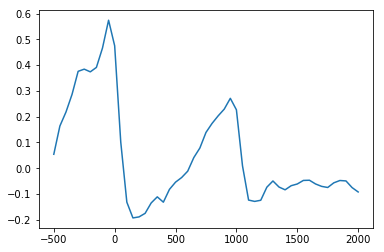

In [28]:
plt.plot(time_window_dict['outcome'],np.mean(outcomes[unrew_sel], axis=0))

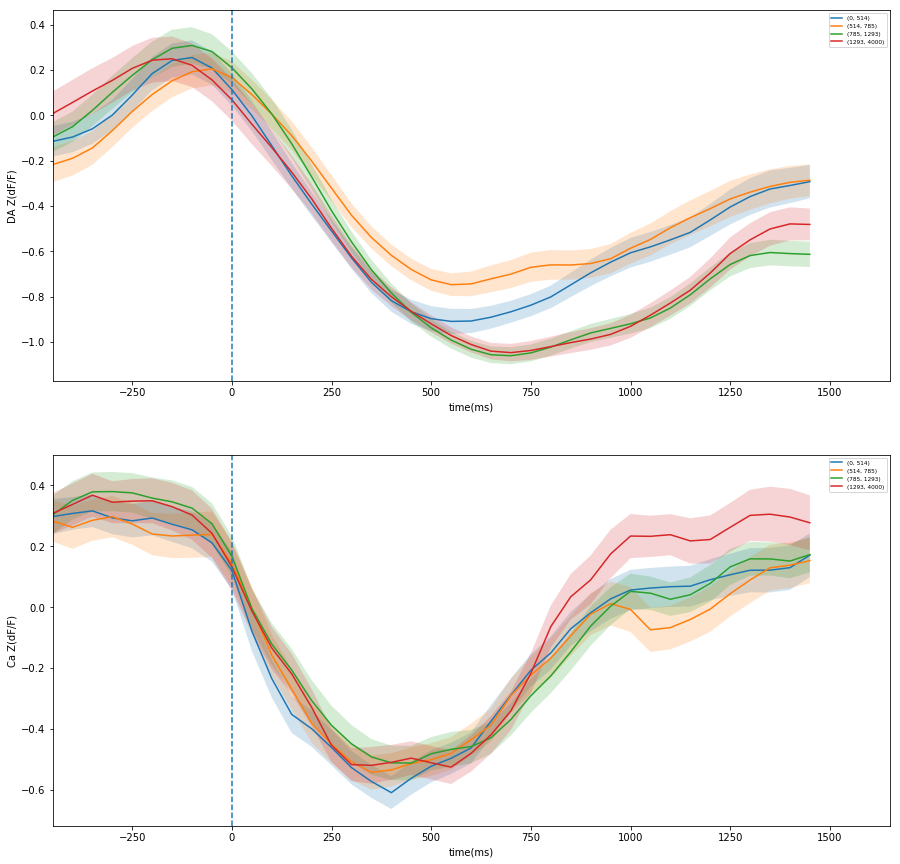

In [162]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
event_arg = 'outcome{t-1}'
behavior_arg = event_arg.split('{')[0]
for i, sig in enumerate(['DA', 'Ca']):
    
    outcomes = aligned[i][behavior_time_map[event_arg]]
    twindow = time_window_dict[behavior_arg]
    tmin, tmax = -500, 1500
    tsel = (twindow > tmin) & (twindow < tmax)
    unrewout2 = outcomes[unrew_sel, :][:, tsel]
    c22 = sns.diverging_palette(240, 10, n=4)
    labels = [f'(0, {int(unrew_bins[0])})', f'({int(unrew_bins[0])}, {int(unrew_bins[1])})', 
              f'({int(unrew_bins[1])}, {int(unrew_bins[2])})', f'({int(unrew_bins[2])}, {int(unrew_bins[3])})']
    urbined_outcome = [unrewout2[unrew_bin1], unrewout2[unrew_bin2], unrewout2[unrew_bin3], unrewout2[unrew_bin4]]
    peristimulus_time_trial_average_plot(urbined_outcome, 
                                         twindow[tsel],
                                         tags=(None, 'time(ms)', 
                                               f'{sig} Z(dF/F)', labels), ax=axes[i])
    axes[i].set_xlim((tmin * 0.9, tmax * 1.1))
#fig.savefig('DACa_multiplex.png')

### PCA analysis mvmt times vs mean vs peak

In [ ]:
event_arg = 'outcome{t-1}'
beh_arg = event_arg.split('{')[0]
action_arg = 'A{t-1}'

fmat_plot = fmat0[logsel]
all_bins = [f'bin{i}' for i in range(1, 5)]

(138, 527)


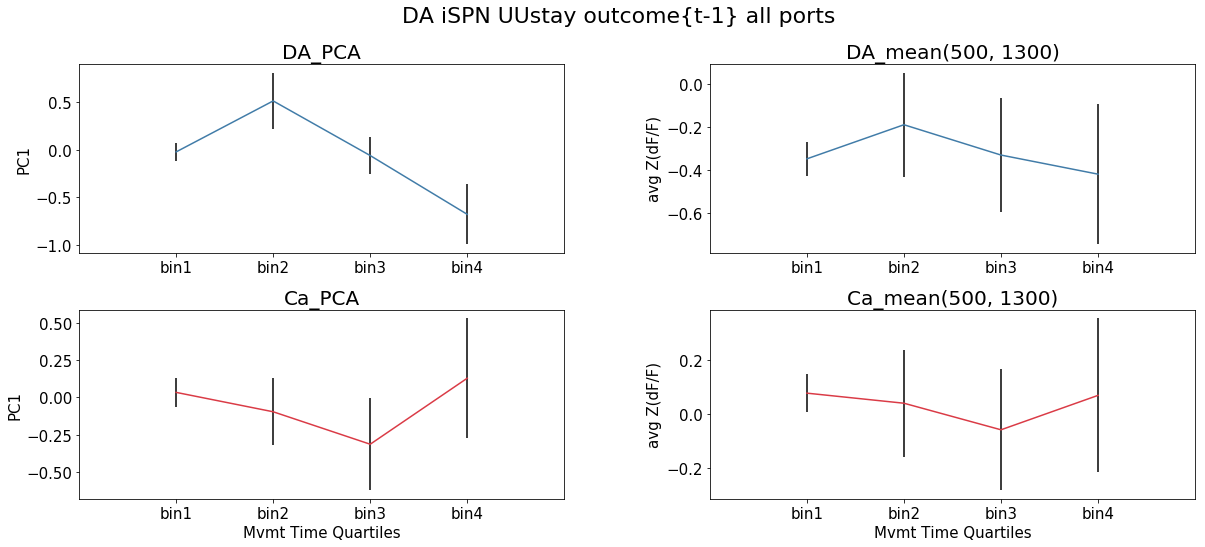

In [86]:
event_arg = 'outcome{t-1}'
behavior_arg = event_arg.split('{')[0]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,8))
plt.subplots_adjust(hspace=0.2, wspace=0.3)
colors = sns.diverging_palette(240, 10, n=2)
fmat0 = drop_empty_nan(giant_eventFP_mat)
#animal, session = 'A2A', 'all'
animal, session = "A2A-15B-B_RT", "p153_FP_LH"
if len(animal) > 3:
    fmat0 = fmat0[fmat0['animal'] == animal]
if session != 'all':
    fmat0 = fmat0[fmat0['session'] == session]
logsel = (fmat0['R{t-1}'] == 'U') & (
    fmat0['R{t-2}'] == 'U') & (fmat0['A{t-1}'] == fmat0['A{t-2}'])
cond_arg = 'UUstay'
fmat_plot = fmat0[logsel]
print(fmat_plot.shape)
all_bins = [f'bin{i}' for i in range(1, 5)]

for i, sig in enumerate(['DA', 'Ca']):
    column_sel = get_columns_FP_df(fmat_plot, sig+f'_{event_arg}')
    fluor_mat = fmat_plot[column_sel]
    twindow = time_window_dict[behavior_arg]
    #print(outcomes.shape, unrew_sel.shape, unrew_bin1.shape)
    #outcomes = aligned[i][behavior_time_map['side_out{t-1}']]
    #print(outcomes.shape)
    ek = f'{sig}_{event_arg}'
    transforms = eventFP_mat_dimred(fmat_plot, ek, twindow >=0, 1)
    series1 = [transforms.values.ravel()[fmat_plot['MVT_binN'].values == bb] for bb in all_bins]
#     # Random Conjecture
#     mvm_nonansel = ~np.isnan(mvmt_times)
#     #print(mvmt_times.shape, np.sum(mvm_nonansel), unrew_sel.shape, transforms.shape)
#     v1, v2 = mvmt_times[nonan_sel][unrew_sel], transforms[unrew_sel][:, 0]
#     axes[i, 0].scatter(v1[~np.isnan(v1)], v2[~np.isnan(v2)])
#     axes[i, 0].set_xlim((0, 4000))

    tstart, tend = 500, 1300
    #tstart, tend = 0, 600
    selector = (twindow >= tstart) & (twindow <= tend)
    #selector = (time_window_dict['side_out'] >= tstart) & (time_window_dict['side_out'] <= tend)
    
    #mm = np.mean(outcomes[:, selector])
    mm=0
    
    series2 = [fluor_mat.loc[fmat_plot['MVT_binN'] == bb, column_sel].values for bb in all_bins]
#     tstart2, tend2 = -500, 1000
#     #mm2 = np.mean(np.max(outcomes[:, selector], axis=1))
#     mm2 = 0
#     unrewout2 = np.max(fluor_mat[unrew_sel, :][:, selector], axis=1)
#     series3 = [unrewout2[unrew_bin1]-mm2,
#                unrewout2[unrew_bin2]-mm2,
#                unrewout2[unrew_bin3]-mm2,
#                unrewout2[unrew_bin4]-mm2]
    #targs = ['_PCA', f'_mean({tstart}, {tend})', f'_max({tstart2}, {tend2})']
    targs = ['_PCA', f'_mean({tstart}, {tend})']
    for j, series in enumerate([series1, series2]):
        axes[i][j].errorbar([0, 1, 2, 3], [np.mean(series[i]) for i in range(4)], 
                            yerr=[np.std(series[i]) / np.sqrt(len(series[i])) for i in range(4)], 
                            c=colors[i], ecolor='k')
        axes[i][j].set_xticks([0, 1, 2, 3])
        axes[i][j].set_xlim([-1, 4])
        axes[i][j].set_xticklabels(all_bins, rotation=0)
        if i == 1:
            axes[i][j].set_xlabel('Mvmt Time Quartiles')
        axes[i][j].set_title(sig + targs[j])
        if j == 0:
            axes[i][j].set_ylabel('PC1')
        elif j == 1:
            axes[i][j].set_ylabel('avg Z(dF/F)')
neurtype = {'A2A': 'iSPN', 'D1': 'dSPN'}[animal if len(animal) <= 3 else animal.split('-')[0]]
fig.suptitle(f'DA {neurtype} {cond_arg} {event_arg} all ports')
plt.subplots_adjust(hspace=0.3)
plt.savefig(os.path.join(plot_out, f'avg_evol_DACa_{event_arg}_MVT_bin_{cond_arg}_{animal}_{session}.png'))

### Plotting thery

In [ ]:
def get_1est(iters=1000):
    results = []
    for _ in range(iters):
        X = np.random.normal(0, 1, (100, 100))
        est1 = np.max(np.mean(X, axis=1))
        est2 = np.mean(np.max(X, axis=0))
        results.append([est1, est2])
    return np.array(results)
results = get_1est()
maxMean, meanMax = results[:, 0], results[:, 1]
fig,axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
sns.distplot(maxMean, label='maxMean', kde=False, ax=axes[0])
sns.distplot(meanMax, label='meanMax', kde=False,ax=axes[0])
axes[0].legend()
axes[1].bar([0, 1], [np.mean(maxMean), np.mean(meanMax)], yerr=[np.std(maxMean), np.std(meanMax)])
print([np.std(maxMean), np.std(meanMax)])

In [ ]:
np.repeat(np.array(list('abcd')), 2)

In [ ]:
np.core.defchararray.add(labels, np.array(list('abcd')))

In [21]:
def logistic_regression_mat(rew_feature, lat_feature, extra_feature, tags, lag=4, use_scikit=True):
    # if extra_feature shape == 2, must tile with rew_features
    # extra feature could be passed as dictionary but oh well
    rews, unrews = rew_feature['Rewarded'], rew_feature['Unrewarded']
    ipsis, contras = lat_feature['ipsi'], lat_feature['contra'].astype(np.float)
    # contra: 1, ipsi: -1
    rew_lat = np.vstack([rews * (contras - ipsis), unrews * (contras - ipsis)])
    rewlat_labels = np.concatenate([['rew_lat{t-%d}' % i, 'unrew_lat{t-%d}' % i] for i in range(1, lag+1)])
    Xlags = lagmat(rew_lat.T, maxlag=lag, trim="both", original='ex')
    print(Xlags.shape)
    #lags = np.vstack([rew_lat[:, 3:-1], rew_lat[:, 2:-2], rew_lat[:, 1:-3], rew_lat[:, 0:-4]]).T
    # [X4_iti1 (8) ... X4_iti4 (8)]
    print(rewlat_labels.shape, np.repeat(tags, Xlags.shape[1]).shape)
    all_tags = np.core.defchararray.add(np.tile(rewlat_labels, len(tags)), np.repeat(tags, Xlags.shape[1]))
    
    if len(extra_feature[0].shape) == 1:
        for i in len(extra_feature):
            extra_feature = extra_feature[:, np.newaxis]
        design_mat = np.hstack([np.tile(extra_feature[i][lag:], Xlags.shape[1]) * Xlags for i in range(len(tags))])
    else:
        assert extra_feature[0].shape[1] == 2, 'Has to be same as reward dimension'
        design_mat = np.hstack([np.tile(extra_feature[i][lag:], Xlags.shape[1] // 2) * Xlags for i in range(len(tags))]) 
    assert design_mat.shape[1] == Xlags.shape[1] * len(tags)
    Y = np.zeros(Xlags.shape[0]) + contras[lag:] - ipsis[lag:]
    sel = Y != 0
    return design_mat[sel], Y[sel], all_tags

def bootstrap_Logistic_Regression(X, y, k_iters=1000, alpha=0.05, full_dist=False, use_scikit=True):
    coeffmat = [0] * k_iters
    for i in range(k_iters):
        sample_index = np.random.choice(len(y), len(y))
        X_samples = X[sample_index]
        y_samples = y[sample_index]
        if use_scikit:
#             coeffmat[i] = LogisticRegressionCV(cv=10, solver='saga', penalty='l1', 
#                                                random_state=0, max_iter=500).fit(X_samples, y_samples).coef_
            coeffmat[i] = LogisticRegression(fit_intercept=True, solver=solver).fit(X_samples, y_samples).coef_
        else:
            # statsmodels
            X_samples = sm.add_constant(X_samples)
            coeffmat[i] = sm.Logit((y_samples + 1) // 2, X_samples).fit_regularized(disp=0).params[1:]
    coeffmat = np.vstack(coeffmat)
    beta_lb = np.percentile(coeffmat, (alpha / 2) *100, axis=0)
    beta_ub = np.percentile(coeffmat, (1 - alpha / 2)*100, axis=0)
    if use_scikit:
        full_beta = LogisticRegression(fit_intercept=True, solver='lbfgs').fit(X, y).coef_
    else:
        X_stm = sm.add_constant(X)
        full_beta = sm.Logit((y + 1) // 2, X_stm).fit_regularized(disp=0).params[1:]
    if full_dist:
        return coeffmat
    else:
        return full_beta, beta_lb, beta_ub
    
def bootstrap_model_coef(X, y, fit_coef, k_iters=1000, alpha=0.05, full_dist=False, smreg=False):
    coeffmat = [0] * k_iters
    for i in range(k_iters):
        sample_index = np.random.choice(len(y), len(y))
        X_samples = X[sample_index]
        y_samples = y[sample_index]
        if smreg:
            assert (len(np.unique(y)) == 2) & np.allclose(np.sort(np.unique(y)), 
                                                          np.arange(2)), 'has to be binary for statsmodel' 
            X_samples = sm.add_constant(X_samples)
            coeffmat[i] = fit_coef(X_samples, y_samples)
        else:
            coeffmat[i] = fit_coef(X_samples, y_samples)
    coeffmat = np.vstack(coeffmat)
    beta_lb = np.percentile(coeffmat, (alpha / 2) *100, axis=0)
    beta_ub = np.percentile(coeffmat, (1 - alpha / 2)*100, axis=0)
    if use_scikit:
        full_beta = fit_coef(X, y)
    else:
        X_stm = sm.add_constant(X)
        #full_beta = sm.Logit((y + 1) // 2, X_stm).fit_regularized(disp=0).params[1:]
        full_beta = fit_coef(X_stm, y)
    if full_dist:
        return coeffmat
    else:
        return full_beta, beta_lb, beta_ub

#### Note: Some confusions about the inconsistency between Xlag mat 
Here the indices are placed on `A` and `R{t-1}`, the following expression evaluates True:
`np.allclose(rew_outcome['Rewarded'][1:], (feature_mat['R'] == 'R')[:-1])`
Deliverable: Fix the pipeline!

Seems like a common procedure here is: get raw event features (time lag them if applicable), return a `pd.DataFrame`

Observation 1: Log Regression Rew/Choice history performs 0.85 validation accuracy

True

In [91]:
lag = 4
trial_lat = get_trial_features_old(mat, 'A', False)
rew_feat = get_trial_features_old(mat, 'R', False)
# iti_bins = [np.vstack((rew_iti_bins[i], unrew_iti_bins[i])).T for i in range(4)]
rews, unrews = rew_feat['Rewarded'], rew_feat['Unrewarded']
ipsis, contras = trial_lat['ipsi'], trial_lat['contra'].astype(np.float)
# contra: 1, ipsi: -1
rew_lat = np.vstack([rews * (contras - ipsis), unrews * (contras - ipsis)])
rewlat_labels = np.concatenate([['rew_lat{t-%d}' % i, 'unrew_lat{t-%d}' % i] for i in range(1, lag+1)])
Xlags = lagmat(rew_lat.T, maxlag=lag, trim="both", original='ex')
Y = np.zeros(Xlags.shape[0]) + contras[lag:] - ipsis[lag:]
y_valid_sel = Y != 0
stay_sel = (trial_lat['contra'][3:-1] & 
            trial_lat['contra'][2:-2]) | (trial_lat['ipsi'][3:-1] & 
                                          trial_lat['ipsi'][2:-2])
uu_sel = rew_feat['Unrewarded'][3:-1] & rew_feat['Unrewarded'][2:-2]
triple_sel = (stay_sel&uu_sel)[y_valid_sel]
designmat, y = Xlags[y_valid_sel], Y[y_valid_sel]
y = (y + 1) / 2
# designmat, y, param_names = logistic_regression_mat(rew_feat, trial_lat, iti_bins, ['bin1', 'bin2', 'bin3', 'bin4']) # Needs separate bin

In [84]:
# Sanity Check: feature consistency Passed
# uu_sel2 = ((feature_mat['R{t-2}'] == 'U') & (feature_mat['R{t-1}'] == 'U')).values[4:]
# np.allclose(uu_sel, uu_sel2)
# alt_sel = (feature_mat['R{t-2}'] == 'U') & (feature_mat['R{t-1}'] == 'U') & (feature_mat['A{t-1}'] == feature_mat['A{t-2}'])
# bsel = (feature_mat['A'] != '')
# feature_mat[alt_sel&bsel].shape
# Xlags[y_valid_sel&stay_sel&uu_sel].shape
# log_model = sm.Logit(y, sm.add_constant(designmat))
# res = log_model.fit_regularized(disp=0)
# new_label = statsmodel_logreg(res, designmat)
# np.sum(new_label == y) / len(y)
log_model_choice1 = LogisticRegressionCV(cv=5, solver='saga', 
                                        penalty='l1', random_state=0, max_iter=1000).fit(designmat, y)
log_model_choice1.score(designmat, y), sklearn_logregcv_best_score(log_model_choice1)

(0.8519195612431444, 0.8537472246659126)

In [174]:
log_model_choice1.score(designmat[triple_sel], y[triple_sel])

0.5416666666666666

In [133]:
def get_correct_port_side_feature(mat):
    portside = np.array(mat['glml/value/cue_port_side'])[:, 0]
    hemi = np.array(mat['glml/notes/hemisphere']).item()
    portside[portside == 2] = 0
    res = np.full(len(portside), 'contra')
    res[portside == hemi] = 'ipsi'
    return res

In [136]:
cpsides = get_correct_port_side_feature(mat)

In [88]:
def statsmodel_logreg(regres, X):
    if X.shape[1] == len(regres.params) - 1:
        X = sm.add_constant(X)
    return (res.predict(sm.add_constant(X)) >= 0.5).astype(np.float)

In [172]:
aa, rr = feature_mat['A'].values, feature_mat['R'].values
tt = np.arange(len(aa))
c1 = (aa[4:] == 'ipsi') & (aa[3:-1] == 'ipsi') & (aa[2:-2] == 'ipsi') & (aa[1:-3] == 'ipsi') & (aa[0:-4] == 'contra')
c2 = (rr[4:] == 'U') & (rr[3:-1] == 'U') & (rr[2:-2] == 'U') & (rr[1:-3] == 'U') & (rr[0:-4] == 'U')
np.sum(c1&c2)

5

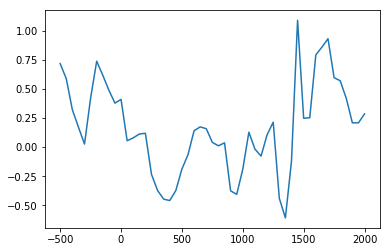

In [205]:
plt.plot(time_window_dict['outcome'], eventFP_mat.loc[322, get_columns_FP_df(eventFP_mat, 'Ca_outcome{t-1}')])

In [173]:
kk = np.where(c1&c2)[0][0]
pd.DataFrame({'trial': tt[4:][kk-40:kk+5],
              'A': aa[4:][kk-40:kk+5],
              'R': rr[4:][kk-40:kk+5],
              'CP': cpsides[4:][kk-40:kk+5]})
# print(aa[4:][kk-20:kk+1], aa[4:][kk+1:kk+5])
# print(rr[4:][kk-20:kk+1], rr[4:][kk+1:kk+5])

,trial,A,R,CP
0,282,contra,U,ipsi
1,283,ipsi,R,ipsi
2,284,ipsi,R,ipsi
3,285,ipsi,R,ipsi
4,286,ipsi,R,ipsi
5,287,ipsi,R,ipsi
6,288,ipsi,R,ipsi
7,289,ipsi,U,ipsi
8,290,ipsi,R,ipsi
9,291,ipsi,R,ipsi


In [107]:
from sklearn.utils import shuffle
df = shuffle(lala[lala['true'] != lala['pred']])
df

,true,pred,A{t-1},rew_lat{t-1},unrew_lat{t-1},rew_lat{t-2},unrew_lat{t-2},rew_lat{t-3},unrew_lat{t-3},rew_lat{t-4},unrew_lat{t-4}
73,1.0,0.0,0.0,-0.0,-1.0,-0.0,-1.0,0.0,1.0,0.0,1.0
6,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,-0.0,-1.0
46,0.0,1.0,0.0,-0.0,-1.0,-0.0,-1.0,-0.0,-1.0,-0.0,-1.0
29,1.0,0.0,0.0,-0.0,-1.0,-0.0,-1.0,-1.0,-0.0,-1.0,-0.0
128,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
45,0.0,1.0,0.0,-0.0,-1.0,-0.0,-1.0,-0.0,-1.0,-0.0,-1.0
104,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
85,0.0,1.0,0.0,-0.0,-1.0,-0.0,-1.0,0.0,1.0,-0.0,-1.0
124,0.0,1.0,0.0,-0.0,-1.0,-0.0,-1.0,0.0,1.0,-0.0,-1.0


In [177]:
np.sum(lala['pred'] == lala['A{t-1}']), np.sum(lala['pred'] != lala['A{t-1}']) # Stay Bias?

(77, 67)

In [148]:
lala =pd.DataFrame({'true': y[triple_sel], 
              'pred': log_model_choice1.predict(designmat[triple_sel]), 
              'A{t-1}': trial_lat['contra'][3:-1][stay_sel&uu_sel&y_valid_sel].astype(np.float),
              'correct_port': (cpsides[4:][stay_sel&uu_sel&y_valid_sel] == 'contra').astype(np.float)})
lala = pd.concat([lala, pd.DataFrame(designmat[triple_sel], columns=rewlat_labels)], axis=1)
print('UU performance:', log_model_choice1.score(designmat[triple_sel], y[triple_sel]))
shuffle(lala[lala['true'] != lala['pred']])

UU performance: 0.5416666666666666


,true,pred,A{t-1},correct_port,rew_lat{t-1},unrew_lat{t-1},rew_lat{t-2},unrew_lat{t-2},rew_lat{t-3},unrew_lat{t-3},rew_lat{t-4},unrew_lat{t-4}
140,0.0,1.0,0.0,1.0,-0.0,-1.0,-0.0,-1.0,-0.0,-1.0,0.0,1.0
46,0.0,1.0,0.0,1.0,-0.0,-1.0,-0.0,-1.0,-0.0,-1.0,-0.0,-1.0
104,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
25,0.0,1.0,0.0,0.0,-0.0,-1.0,-0.0,-1.0,0.0,1.0,-0.0,-1.0
83,0.0,1.0,0.0,0.0,-0.0,-1.0,-0.0,-1.0,-0.0,-1.0,-1.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
23,1.0,0.0,0.0,1.0,-0.0,-1.0,-0.0,-1.0,-1.0,-0.0,-1.0,-0.0
28,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,-0.0,-1.0,-1.0,-0.0
29,1.0,0.0,0.0,0.0,-0.0,-1.0,-0.0,-1.0,-1.0,-0.0,-1.0,-0.0
116,0.0,1.0,0.0,1.0,-0.0,-1.0,-0.0,-1.0,0.0,1.0,1.0,0.0


In [23]:
lala =pd.DataFrame({'true': y[triple_sel], 
              'pred': log_model_choice1.predict(designmat[triple_sel]), 
              'A{t-1}': trial_lat['contra'][3:-1][stay_sel&uu_sel&y_valid_sel]})

In [34]:
np.sum((lala['true'] == 1) == lala['A{t-1}'])

63

In [259]:
np.max(np.mean(np.mean([log_model_choice1.scores_[b] for b in log_model_choice.scores_], axis=0), 
                                                    axis=0))

0.769632608604583

In [ ]:
trial_lat = get_trial_features_old(mat, 'A', False)
iti_bins = [np.vstack((rew_iti_bins[i], unrew_iti_bins[i])).T for i in range(4)]
designmat, y, param_names = logistic_regression_mat(rew_outcome, trial_lat, iti_bins, ['bin1', 'bin2', 'bin3', 'bin4']) # Needs separate bin

beta_full, beta_lb, beta_ub = bootstrap_Logistic_Regression(designmat, y, use_scikit=False)
# Xskl = designmat
# skl_logreg = LogisticRegression(fit_intercept=True, solver='lbfgs').fit(Xskl, y)
# coeffs_skl = skl_logreg.coef_

# Statsmodel TODO: rerun analysis with statsmodel implementation
# Xstats = designmat
# Xstats = sm.add_constant(Xstats)
# stats_logit = sm.Logit((y + 1) // 2, Xstats)
# coeffs_stats = stats_logit.fit().params

beta_ub[ews[3]], beta_lb[ews[3]]

In [ ]:
# Statsmodels biased estimate?
xs = np.arange(4)
ews = [weights['unrew_lat']['bin1'][0], weights['unrew_lat']['bin2'][0], 
       weights['unrew_lat']['bin3'][0], weights['unrew_lat']['bin4'][0]]

plt.errorbar(xs, [beta_full[ew] for ew in ews])
plt.fill_between(xs, [beta_lb[ew] for ew in ews], [beta_ub[ew] for ew in ews], alpha=0.2)

In [ ]:
# plt.figure(figsize=(20, 20))
# sort_names = np.argsort(param_names)
# plt.barh(np.arange(32), coeffs.ravel()[sort_names])
# _ = plt.yticks(np.arange(32), param_names[sort_names])
LAG = 4
binargs = ['bin1', 'bin2', 'bin3', 'bin4']
weights = {'rew_lat': {ba: [0] * LAG for ba in binargs},
           'unrew_lat': {ba: [0] * LAG for ba in binargs}}
lag_seq = np.arange(-LAG, 0)
for i, pn in enumerate(param_names):
    first, mid = pn.split('{')
    mid, last = mid.split('}')
    ind = int(mid[1:]) + LAG
    #print(ind, first, last, mid)
    weights[first][last][ind] = i


plt.figure(figsize=(10, 10))
colors = sns.color_palette("icefire", LAG*4-1)
#colors = sns.diverging_palette(240, 10, n=LAG*4+1)
def plot_helper(k1, k2, sal, i):
    bfull = [beta_full[weights[k1][k2][j]] for j in range(LAG)]
    blb = [beta_lb[weights[k1][k2][j]] for j in range(LAG)]
    bub = [beta_ub[weights[k1][k2][j]] for j in range(LAG)]
    plt.plot(xs, bfull, 'o-', label=sal, c=colors[i])
    plt.fill_between(xs, blb, bub, alpha=0.2, color=colors[i])
    #plt.errorbar(xs, bfull, yerr=[blb, bub], label=sal, c=colors[i])


xs = np.arange(LAG)
plot_helper('rew_lat', 'bin1', f'R {rew_intervals_tags[0]}', 0)
plot_helper('rew_lat', 'bin2', f'R {rew_intervals_tags[1]}', 2)
plot_helper('rew_lat', 'bin3', f'R {rew_intervals_tags[2]}', 4)
plot_helper('rew_lat', 'bin4', f'R {rew_intervals_tags[3]}', 6)
plot_helper('unrew_lat', 'bin4', f'UR {unrew_intervals_tags[3]}', 8)
plot_helper('unrew_lat', 'bin3', f'UR {unrew_intervals_tags[2]}',10)
plot_helper('unrew_lat', 'bin2', f'UR {unrew_intervals_tags[1]}', 12)
plot_helper('unrew_lat', 'bin1', f'UR {unrew_intervals_tags[0]}', 14)
plt.xticks(xs, lag_seq)
plt.legend(loc='upper left')
plt.title('4 Trials Back Logistic Regression')
plt.savefig("log_regression_statsmodels.png")

### Decision Tree

In [ ]:
ys = pd.DataFrame({trial_feature: get_trial_features_old(mat, trial_feature, True)[nonan_sel]})
mat.close()
for i in range(len(fp_sigs)):
    aligned[i] = np.hstack(aligned[i])

regrs, clfrs = [], []
for i in range(len(fp_sigs)):
    raw_features = np.concatenate(
        [[beh + f'{ts:.0f}ms' for ts in time_window_dict[beh.split('{')[0]]] for beh in event_types])
    if is_numeric_dtype(ys[trial_feature]):
        models = {'raw': (None, aligned[i])}
        reg_results = regression_multi_models(models, ys, method=fit_models,
                                              N_iters=3, raw_features_names=raw_features,
                                              reg_params=None, show=True)
        regrs.append(reg_results)
    else:
        # TODO: clf add feature importances
        noNA = (ys != 'NA').values.ravel()
        models = {'raw': (None, aligned[i][noNA])}
        clfs, confs = classifier_LD_multimodels(models, ys[trial_feature][noNA], LD_dim=None,
                                                N_iters=100,
                                                mode='true', ignore_labels=None,
                                                clf_models=fit_models, clf_params=None,
                                                cluster_param=3, label_alias=None, show=True)
        clfrs.append((clfs, confs))
i=0
fit_models = ['RandomForests']
for md in fit_models:
    visualize_feature_importance(clfrs[i][0]['raw'][md]['f_importance'], raw_features, thres=40,
                                 tag=f'{tags[i]}_{md}_{trial_feature}')

In [ ]:
folder = "/Users/albertqu/Documents/7.Research/Wilbrecht_Lab/CADA_data/ProbSwitch_FP_data"
animal, session = "A2A-15B-B_RT", "p153_FP_LH"
event_types = ['center_in', 'center_out', 'outcome{t-1}', 'outcome{t-2}', 'side_out{t-1}']
trial_feature = "ITI_raw"
zscore=True
base_method='robust_fast'
denoise=True

### ITI

In [ ]:
    time_window_dict = {'center_in': np.arange(-500, 501, 50),
                        'center_out': np.arange(-500, 501, 50),
                        'outcome': np.arange(-500, 2001, 50),
                        'side_out': np.arange(-500, 1001, 50)}
    tags = ['DA', 'Ca']
    fit_models = ['RandomForests']

    files = encode_to_filename(folder, animal, session)
    matfile, green, red, fp = files['behavior'], files['green'], files['red'], files['FP']
    # Load FP
    if fp is not None:
        with h5py.File(fp, 'r') as fp_hdf5:
            fp_sigs = [access_mat_with_path(fp_hdf5, f'{tags[i]}/dff/{base_method}')
                       for i in range(len(tags))]
            if zscore:
                fp_sigs = [(fp_sigs[i] - np.mean(fp_sigs[i])) / np.std(fp_sigs[i], ddof=1)
                           for i in range(len(fp_sigs))]
            fp_times = [access_mat_with_path(fp_hdf5, f'{tags[i]}/time') for i in
                        range(len(tags))]
    else:
        print(f"Warning {animal} {session} does not have photometry processed!")
        fp_times, fp_sigs, iso_times, iso_sigs = get_sources_from_csvs([green, red],
                                                                       tags=('DA', 'Ca'), show=False)

        fp_sigs = [raw_fluor_to_dff(fp_times[i], fp_sigs[i], iso_times[i], iso_sigs[i], base_method,
                                    zscore=zscore) for i in range(len(fp_sigs))]
    if denoise:
        L = len(fp_times)
        new_times, new_sigs = [None] * L, [None] * L
        for i in range(L):
            new_sigs[i], new_times[i] = denoise_quasi_uniform(fp_sigs[i], fp_times[i])
        fp_sigs, fp_times = new_sigs, new_times
        # TODO: for now just do plots for one session

    mat = h5py.File(matfile, 'r')
    # Get aligned signals to behaviors
    aligned = [[] for _ in range(len(fp_sigs))]
    behavior_times = np.vstack([get_behavior_times(mat, beh) for beh in event_types])
    nonan_sel = ~np.any(np.isnan(behavior_times), axis=0)
    behavior_times_nonan = behavior_times[:, nonan_sel]
    for ib, beh in enumerate(event_types):
        # TODO: ADD caps for multiple behavior time latencies
        for i in range(len(fp_sigs)):
            aligned[i].append(align_activities_with_event(fp_sigs[i], fp_times[i], behavior_times_nonan[ib],
                                                          time_window_dict[beh.split('{')[0]], False))

    ys = pd.DataFrame({trial_feature: get_trial_features_old(mat, trial_feature, True)[nonan_sel]})
    mat.close()
    for i in range(len(fp_sigs)):
        aligned[i] = np.hstack(aligned[i])

    regrs, clfrs = [], []
    for i in range(len(fp_sigs)):
        raw_features = np.concatenate(
            [[beh + f'{ts:.0f}ms' for ts in time_window_dict[beh.split('{')[0]]] for beh in event_types])
        if is_numeric_dtype(ys[trial_feature]):
            models = {'raw': (None, aligned[i])}
            reg_results = regression_multi_models(models, ys, method=fit_models,
                                                  N_iters=3, raw_features_names=raw_features,
                                                  reg_params=None, show=True)
            regrs.append(reg_results)

In [ ]:
i=0
for md in fit_models:
    visualize_feature_importance(regrs[i]['raw'][md]['f_importance'], raw_features,
                                 tag=f'{tags[i]}_{md}_{trial_feature}')

In [ ]:
folder = "/Users/albertqu/Documents/7.Research/Wilbrecht_Lab/CADA_data/ProbSwitch_FP_data"
animal, session = "A2A-15B-B_RT", "p153_FP_LH"
event_types = ['center_in', 'center_out', 'outcome{t-1}', 'outcome{t-2}', 'side_out{t-1}']
trial_feature = "ITI"
zscore=True
base_method='robust_fast'
denoise=True

In [ ]:
i=1
for md in fit_models:
    visualize_feature_importance(regrs[i]['raw'][md]['f_importance'], raw_features,
                                 tag=f'{tags[i]}_{md}_{trial_feature}')